In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics import precision_score, recall_score
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, TensorDataset
import faiss
import numpy as np

D:\Anaconda\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [3]:
# Load datasets
users = pd.read_csv('processed_dataset/MovieLens-1M/users/users_movielens.csv')
movies = pd.read_csv('processed_dataset/MovieLens-1M/movies/movies_movielens.csv')
train_ratings = pd.read_csv('processed_dataset/MovieLens-1M/ratings/traindata_movielens.csv')
val_ratings = pd.read_csv('processed_dataset/MovieLens-1M/ratings/valdata_movielens.csv')
test_ratings = pd.read_csv('processed_dataset/MovieLens-1M/ratings/testdata_movielens.csv')

In [4]:
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
# sbert_model = SentenceTransformer("intfloat/e5-small-v2")
# sbert_model = SentenceTransformer("all-mpnet-base-v2")

D:\Anaconda\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
sbert_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [6]:
train_ratings

user_id  item_id  rating   timestamp
0          6040      593       5   956703954
1          6040     1961       4   956703977
2          6040     2019       5   956703977
3          6040     1419       3   956704056
4          6040     3505       4   956704056
...         ...      ...     ...         ...
600120      403     1036       4  1046388675
600121     5948     1180       5  1046437879
600122     5948     3098       4  1046437932
600123     4958     1407       5  1046454443
600124     4958     3264       4  1046454548

[600125 rows x 4 columns]

In [7]:
# def generate_user_embeddings_with_history(users, movies, ratings):
#     user_histories = {user_id: [] for user_id in users['user_id'].unique()}
#     user_embeddings = []
#
#     for _, row in ratings.iterrows():
#         user_id = row['user_id']
#         movie_id = row['item_id']
#
#         # Get user features
#         user = users.loc[users['user_id'] == user_id].iloc[0]
#         user_features = f"occupation: {user['occupation']} [SEP] age: {user['age']} [SEP] gender: {user['gender']}"
#
#         # Append the user's history
#         history_movies = [movies.loc[movies['item_id'] == mid]['title'].values[0] for mid in user_histories[user_id]]
#         history_str = ", ".join(history_movies)
#
#         # Combine user features and history
#         if (len(history_str) != 0):
#             combined_features = f"{user_features} [SEP] history: {history_str}"
#         else:
#             combined_features = f"{user_features}"
#
#         user_embeddings.append(combined_features)
#
#         # Update the user history after generating combined features
#         user_histories[user_id].append(movie_id)
#     return user_embeddings

In [8]:
def generate_user_embeddings_with_history(users, movies, ratings):
    user_histories = {user_id: [] for user_id in users['user_id'].unique()}
    user_embeddings = []

    # Convert relevant columns to dictionaries for faster access
    user_features_dict = users.set_index('user_id').to_dict('index')
    movie_titles_dict = movies.set_index('item_id')['title'].to_dict()

    for _, row in ratings.iterrows():
        user_id = row['user_id']
        movie_id = row['item_id']

        # Get user features
        user = user_features_dict[user_id]
        user_features = f"occupation: {user['occupation']} [SEP] age: {user['age']} [SEP] gender: {user['gender']}"

        # Append the user's history (only the last 3 movies)
        history_movies = [movie_titles_dict[mid] for mid in user_histories[user_id][-3:]]
        history_str = ", ".join(history_movies)

        # Combine user features and history
        if history_str:
            combined_features = f"{user_features} [SEP] history: {history_str}"
        else:
            combined_features = f"{user_features}"

        user_embeddings.append(combined_features)

        # Update the user history after generating combined features
        user_histories[user_id].append(movie_id)

    return user_embeddings

In [9]:
train_user_embeddings = generate_user_embeddings_with_history(users, movies, train_ratings)
val_user_embeddings = generate_user_embeddings_with_history(users, movies, val_ratings)
# test_user_embeddings = generate_user_embeddings_with_history(users, movies, test_ratings)

In [10]:
train_user_embeddings

['occupation: doctor/health care [SEP] age: 25-34 [SEP] gender: Male',
 'occupation: doctor/health care [SEP] age: 25-34 [SEP] gender: Male [SEP] history: Silence of the Lambs, The (1991)',
 'occupation: doctor/health care [SEP] age: 25-34 [SEP] gender: Male [SEP] history: Silence of the Lambs, The (1991), Rain Man (1988)',
 'occupation: doctor/health care [SEP] age: 25-34 [SEP] gender: Male [SEP] history: Silence of the Lambs, The (1991), Rain Man (1988), Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)',
 'occupation: doctor/health care [SEP] age: 25-34 [SEP] gender: Male [SEP] history: Rain Man (1988), Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954), Walkabout (1971)',
 'occupation: doctor/health care [SEP] age: 25-34 [SEP] gender: Male [SEP] history: Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954), Walkabout (1971), No Way Out (1987)',
 'occupation: doctor/health care [SEP] age: 25-34 [SEP] gender: Male [SEP] history: Walka

In [8]:
import pickle
# # Save user embeddings locally
# with open('train_user_texts.pkl', 'wb') as f:
#     pickle.dump(train_user_embeddings, f)
#
# print("Train user embeddings saved successfully.")
#
# with open('val_user_texts.pkl', 'wb') as f:
#     pickle.dump(val_user_embeddings, f)
#
# print("Validation user embeddings saved successfully.")
#
# with open('test_user_texts.pkl', 'wb') as f:
#     pickle.dump(test_user_embeddings, f)
#
# print("Test user embeddings saved successfully.")

In [9]:
# Load user embeddings from file
with open('./text_for_embeddings/last_three_history/train_user_texts.pkl', 'rb') as f:
    train_user_texts = pickle.load(f)
print("Train user embeddings loaded successfully.")

with open('./text_for_embeddings/last_three_history/val_user_texts.pkl', 'rb') as f:
    val_user_texts = pickle.load(f)
print("Validation user embeddings loaded successfully.")

with open('./text_for_embeddings/last_three_history/test_user_texts.pkl', 'rb') as f:
    test_user_texts = pickle.load(f)
print("Test user embeddings loaded successfully.")

Train user embeddings loaded successfully.
Validation user embeddings loaded successfully.
Test user embeddings loaded successfully.


In [10]:
train_user_texts[0]

'occupation: doctor/health care [SEP] age: 25-34 [SEP] gender: Male'

In [32]:
# # Convert train, val, and test user texts to embeddings
# train_user_embeddings = torch.tensor(sbert_model.encode(train_user_texts), device='cuda')
# val_user_embeddings = torch.tensor(sbert_model.encode(val_user_texts), device='cuda')
# test_user_embeddings = torch.tensor(sbert_model.encode(test_user_texts), device='cuda')

print("User embeddings for train, validation, and test sets created successfully.")

User embeddings for train, validation, and test sets created successfully.


In [33]:
# # Save embeddings locally
# with open('./train_user_embeddings.pkl', 'wb') as f:
#     pickle.dump(train_user_embeddings.cpu(), f)  # Move to CPU before saving
#
# with open('./val_user_embeddings.pkl', 'wb') as f:
#     pickle.dump(val_user_embeddings.cpu(), f)  # Move to CPU before saving
#
# with open('./test_user_embeddings.pkl', 'wb') as f:
#     pickle.dump(test_user_embeddings.cpu(), f)  # Move to CPU before saving

print("User embeddings saved successfully.")

User embeddings saved successfully.


In [12]:
# Load embeddings from files
with open('./embeddings/MiniLM-L6-v2/last_three_history/train_user_embeddings.pkl', 'rb') as f:
    train_user_embeddings = pickle.load(f).to('cuda')

with open('./embeddings/MiniLM-L6-v2/last_three_history/val_user_embeddings.pkl', 'rb') as f:
    val_user_embeddings = pickle.load(f).to('cuda')

with open('./embeddings/MiniLM-L6-v2/last_three_history/test_user_embeddings.pkl', 'rb') as f:
    test_user_embeddings = pickle.load(f).to('cuda')

print("User embeddings loaded successfully.")

User embeddings loaded successfully.


In [15]:
train_user_embeddings.size()

torch.Size([600125, 384])

In [16]:
movies['movie_features'] = 'title: ' + movies['title'] + ' [SEP] genres: ' + movies['genres']

In [17]:
item_texts = movies['movie_features'].tolist()

In [18]:
item_texts[2936]

'title: Bone Collector, The (1999) [SEP] genres: Thriller'

In [19]:
item_embeddings = torch.tensor(sbert_model.encode(item_texts), device='cuda')

D:\Anaconda\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [20]:
item_embeddings.size()

torch.Size([3883, 384])

In [21]:
# Create a mapping from item_id to its index in the item_embeddings
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(movies['item_id'].unique())}

In [47]:
# Save texts and item embeddings and mapping locally
with open('./text_for_embeddings/item_texts.pkl', 'wb') as f:
    pickle.dump(item_texts, f)

with open('./embeddings/item_embeddings.pkl', 'wb') as f:
    pickle.dump(item_embeddings.cpu(), f)  # Move to CPU before saving

with open('./embeddings/item_id_to_idx.pkl', 'wb') as f:
    pickle.dump(item_id_to_idx, f)

print("Item embeddings and texts and mapping saved successfully.")

Item embeddings and texts and mapping saved successfully.


In [22]:
# Function to create DataLoader
def create_dataloader(user_embeddings, item_id_to_idx, ratings, batch_size=16):
    user_indices = torch.arange(len(user_embeddings)).to('cuda')
    item_indices = torch.LongTensor([item_id_to_idx[item_id] for item_id in ratings['item_id'].values]).to('cuda')
    labels = torch.FloatTensor(ratings['rating'].values).to('cuda')

    dataset = TensorDataset(user_indices, item_indices, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader

In [23]:
# Create DataLoaders
train_dataloader = create_dataloader(train_user_embeddings, item_id_to_idx, train_ratings)
val_dataloader = create_dataloader(val_user_embeddings, item_id_to_idx, val_ratings)
# test_dataloader = create_dataloader(test_user_embeddings, item_id_to_idx, test_ratings)

print("DataLoaders for train, validation, and test sets created successfully.")

DataLoaders for train, validation, and test sets created successfully.


In [24]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
from torchmetrics import Precision, Recall
from pytorch_lightning import Trainer, LightningModule

In [25]:
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from torchmetrics.retrieval import RetrievalPrecision, RetrievalRecall

In [24]:
class TwoTowerModel(LightningModule):
    def __init__(self, embedding_dim, user_embeddings, item_embeddings, criterion, learning_rate=0.001):
        super(TwoTowerModel, self).__init__()
        self.sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
        self.user_embedding_layer = nn.Embedding.from_pretrained(user_embeddings, freeze=False)
        self.item_embedding_layer = nn.Embedding.from_pretrained(item_embeddings, freeze=False)
        self.fc = nn.Linear(embedding_dim * 2, 1)
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.epoch_losses = {'train_loss': [], 'val_loss': []}  # Initialize epoch_losses as a dictionary

        # Initialize metrics
        self.mae = MeanAbsoluteError()
        self.precision_at_k = RetrievalPrecision(top_k=10)
        self.recall_at_k = RetrievalRecall(top_k=10)

        # For accumulating predictions and targets
        self.predictions = []
        self.targets = []
        self.indexes = []

        # Initialize dictionaries to store epoch metrics
        self.epoch_losses = {
            'train_loss': [],
            'val_loss': [],
            'val_precision_at_k': [],
            'val_recall_at_k': [],
            'val_mae': [],
        }

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_embedding_layer(user_indices)
        item_embedding = self.item_embedding_layer(item_indices)
        combined_embeddings = torch.cat((user_embedding, item_embedding), dim=1)
        output = self.fc(combined_embeddings).squeeze()
        return torch.clamp(4 * torch.sigmoid(output) + 1, min=1, max=5)

    def training_step(self, batch, batch_idx):
        user_indices, item_indices, labels = batch
        predictions = self.forward(user_indices, item_indices)
        loss = self.criterion(predictions, labels)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        user_indices, item_indices, labels = batch
        predictions = self.forward(user_indices, item_indices)
        loss = self.criterion(predictions, labels)

        self.predictions.append(predictions)
        self.targets.append((labels > 3.5).int())  # Example threshold for relevance
        self.indexes.append(user_indices)


        # Calculate additional metrics
        mae = self.mae(predictions, labels)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_mae', mae, on_epoch=True, prog_bar=True)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions, targets, and indexes
        predictions = torch.cat(self.predictions)
        targets = torch.cat(self.targets)
        indexes = torch.cat(self.indexes)

        # Compute precision and recall at k
        precision_k = self.precision_at_k(predictions, targets, indexes)
        recall_k = self.recall_at_k(predictions, targets, indexes)

        # Log precision and recall
        self.log('val_precision_at_k', precision_k, on_epoch=True, prog_bar=True)
        self.log('val_recall_at_k', recall_k, on_epoch=True, prog_bar=True)

        # Clear lists for next epoch
        self.predictions.clear()
        self.targets.clear()
        self.indexes.clear()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

    def get_user_embeddings(self, user_indices):
        return self.user_embedding_layer(user_indices)

    def get_item_embeddings(self, item_indices=None):
        if item_indices is None:
            item_indices = torch.arange(self.item_embedding_layer.num_embeddings).to(self.device)
        return self.item_embedding_layer(item_indices)

In [26]:
from pytorch_lightning import Trainer, LightningModule
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
import torch.nn.functional as f

# Define the TwoTowerModel class
class TwoTowerModel(LightningModule):
    def __init__(self, embedding_dim, user_embeddings, item_embeddings, criterion, dropout_rate=0.2, learning_rate=0.001):
        super(TwoTowerModel, self).__init__()
        self.user_embedding_layer = nn.Embedding.from_pretrained(user_embeddings, freeze=False)
        self.item_embedding_layer = nn.Embedding.from_pretrained(item_embeddings, freeze=False)
        self.fc1 = nn.Linear(embedding_dim * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.criterion = criterion
        self.dropout = nn.Dropout(dropout_rate)
        self.learning_rate = learning_rate

        # Initialize metrics
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        self.precision_at_k = torchmetrics.RetrievalPrecision(top_k=10)
        self.recall_at_k = torchmetrics.RetrievalRecall(top_k=10)

        # For accumulating predictions and targets
        self.predictions = []
        self.targets = []
        self.indexes = []

        # Initialize dictionaries to store epoch metrics
        self.epoch_losses = {
            'train_loss': [],
            'val_loss': [],
            'val_precision_at_k': [],
            'val_recall_at_k': [],
            'val_mae': [],
        }

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_embedding_layer(user_indices)
        item_embedding = self.item_embedding_layer(item_indices)
        combined_embeddings = torch.cat((user_embedding, item_embedding), dim=1)
        x = self.fc1(combined_embeddings)
        x = self.dropout(f.relu(x))
        x = self.fc2(x)
        x = self.dropout(f.relu(x))
        output = self.fc3(x).squeeze()
        return torch.clamp(4 * torch.sigmoid(output) + 1, min=1, max=5)

    def training_step(self, batch, batch_idx):
        user_indices, item_indices, labels = batch
        predictions = self.forward(user_indices, item_indices)
        loss = self.criterion(predictions, labels)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        user_indices, item_indices, labels = batch
        predictions = self.forward(user_indices, item_indices)
        loss = self.criterion(predictions, labels)

        # Accumulate predictions, targets, and indexes
        self.predictions.append(predictions)
        self.targets.append((labels > 3.5).int())  # Example threshold for relevance
        self.indexes.append(user_indices)

        # Calculate and log loss
        mse = self.mse(predictions, labels)
        mae = self.mae(predictions, labels)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_mse', mse, on_epoch=True, prog_bar=True)
        self.log('val_mae', mae, on_epoch=True, prog_bar=True)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions, targets, and indexes
        predictions = torch.cat(self.predictions)
        targets = torch.cat(self.targets)
        indexes = torch.cat(self.indexes)

        # Compute precision and recall at k
        precision_k = self.precision_at_k(predictions, targets, indexes)
        recall_k = self.recall_at_k(predictions, targets, indexes)

        # Log precision and recall
        self.log('val_precision_at_k', precision_k, on_epoch=True, prog_bar=True)
        self.log('val_recall_at_k', recall_k, on_epoch=True, prog_bar=True)

        # Clear lists for next epoch
        self.predictions.clear()
        self.targets.clear()
        self.indexes.clear()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

    def get_user_embeddings(self, user_indices):
        return self.user_embedding_layer(user_indices)

    def get_item_embeddings(self, item_indices=None):
        if item_indices is None:
            item_indices = torch.arange(self.item_embedding_layer.num_embeddings).to(self.device)
        return self.item_embedding_layer(item_indices)

In [27]:
# Custom callback to print the losses after each epoch
from pytorch_lightning.callbacks import ModelCheckpoint, Callback

class PrintLossesCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics['train_loss']
        val_loss = trainer.callback_metrics['val_loss']
        val_precision = trainer.callback_metrics.get('val_precision_at_k')
        val_recall = trainer.callback_metrics.get('val_recall_at_k')
        val_mae = trainer.callback_metrics.get('val_mae')
        epoch = trainer.current_epoch
        pl_module.epoch_losses['train_loss'].append(train_loss.item())
        pl_module.epoch_losses['val_loss'].append(val_loss.item())
        pl_module.epoch_losses['val_precision_at_k'].append(val_precision.item())
        pl_module.epoch_losses['val_recall_at_k'].append(val_recall.item())
        pl_module.epoch_losses['val_mae'].append(val_mae.item())
        print(f"Epoch {epoch + 1}: Train Loss: {train_loss}, Val Loss: {val_loss}")



In [28]:
torch.cuda.empty_cache()

In [29]:
# Initialize model
embedding_dim = train_user_embeddings.size()[1]  # Adjust based on your sentence transformer model's output size
criterion = nn.MSELoss()
# model = TwoTowerModel(embedding_dim, user_texts, item_texts, criterion)
model = TwoTowerModel(embedding_dim, train_user_embeddings, item_embeddings, criterion)

logger = TensorBoardLogger("tb_logs", name="all-MiniLM-L6-v2_5-epochs_dropout-0.2_lr-0.001_user-history")

# Setup PyTorch Lightning Trainer
checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1, filename='all-MiniLM-L6-v2_5-epochs_dropout-0.2_lr-0.001_user-history')

trainer = Trainer(
    max_epochs=5,
    logger=logger,
    callbacks=[checkpoint_callback, PrintLossesCallback()],
    enable_progress_bar=True,
)

# Fit the model
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

D:\Anaconda\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `` from `torchmetrics` was deprecated and will be removed in 2.0. Import `` from `torchmetrics.retrieval` instead.
  _future_warning(
D:\Anaconda\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `RetrievalRecall` from `torchmetrics` was deprecated and will be removed in 2.0. Import `RetrievalRecall` from `torchmetrics.retrieval` instead.
  _future_warning(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: tb_l

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 63.18it/s]

D:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
D:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


D:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 37507/37507 [2:21:55<00:00,  4.40it/s, v_num=0, train_loss_step=0.893]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 37507/37507 [2:22:10<00:00,  4.40it/s, v_num=0, train_loss_step=0.239, val_loss=1.040, val_mse=1.040, val_mae=0.827, val_precision_at_k=0.0577, val_recall_at_k=0.577, train_loss_epoch=1.000]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 37507/37507 [2:22:36<00:00,  4.38it/s, v_num=0, train_loss_step=0.0476, val_loss=1.790, val_mse=1.790, val_mae=1.070, val_precision_at_k=0.0577, val_recall_at_k=0.577, train_loss_epoch=0.375]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 37507/37507 [2:22:35<00:00,  4.38it/s, v_num=0, train_loss_step=0.0477, val_loss=2.100, val_mse=2.100, val_mae=1.130, val_precision_at_k=0.0577, val_recall_at_k=0.577, train_loss_epoch=0.121]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 37507/37507 [2:22:34<00:00,  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 37507/37507 [2:26:09<00:00,  4.28it/s, v_num=0, train_loss_step=0.0411, val_loss=2.310, val_mse=2.310, val_mae=1.180, val_precision_at_k=0.0577, val_recall_at_k=0.577, train_loss_epoch=0.0691]


In [99]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   8875 MiB |  10748 MiB | 425404 GiB | 425395 GiB |\n|       from large pool |   8843 MiB |  10701 MiB | 425277 GiB | 425269 GiB |\n|       from small pool |     31 MiB |     47 MiB |    126 GiB |    126 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   8875 MiB |  10748 MiB | 425404 GiB | 425395 GiB |\n|       from large pool |   8843 MiB |  10701 MiB |

In [16]:
tensorboard --logdir tb_logs

SyntaxError: invalid syntax (3304409492.py, line 1)

In [30]:
# Print losses after training completes
print("Epoch losses:")
for epoch in range(trainer.max_epochs):
    print(f"Epoch {epoch + 1}: Train Loss: {model.epoch_losses['train_loss'][epoch]}, Val Loss: {model.epoch_losses['val_loss'][epoch]}")

Epoch losses:
Epoch 1: Train Loss: 1.0012260675430298, Val Loss: 1.0423693656921387
Epoch 2: Train Loss: 0.3746204078197479, Val Loss: 1.7886298894882202
Epoch 3: Train Loss: 0.12138275802135468, Val Loss: 2.102504014968872
Epoch 4: Train Loss: 0.07939162850379944, Val Loss: 2.3196351528167725
Epoch 5: Train Loss: 0.06912137567996979, Val Loss: 2.307332754135132


In [31]:
# Print losses after training completes
print("Epoch losses:")
for epoch in range(trainer.max_epochs):
    print(f"Epoch {epoch + 1}: Train Loss: {model.epoch_losses['train_loss'][epoch]}, Val Loss: {model.epoch_losses['val_loss'][epoch]}, Val Precision@10: {model.epoch_losses['val_precision_at_k'][epoch]}, Val Recall@10: {model.epoch_losses['val_recall_at_k'][epoch]}, Val MAE: {model.epoch_losses['val_mae'][epoch]}")

Epoch losses:
Epoch 1: Train Loss: 1.0012260675430298, Val Loss: 1.0423693656921387, Val Precision@10: 0.05769776925444603, Val Recall@10: 0.5769776701927185, Val MAE: 0.8267256021499634
Epoch 2: Train Loss: 0.3746204078197479, Val Loss: 1.7886298894882202, Val Precision@10: 0.05769676715135574, Val Recall@10: 0.5769676566123962, Val MAE: 1.0726252794265747
Epoch 3: Train Loss: 0.12138275802135468, Val Loss: 2.102504014968872, Val Precision@10: 0.05769626423716545, Val Recall@10: 0.5769626498222351, Val MAE: 1.1349833011627197
Epoch 4: Train Loss: 0.07939162850379944, Val Loss: 2.3196351528167725, Val Precision@10: 0.05769776925444603, Val Recall@10: 0.5769776701927185, Val MAE: 1.1881574392318726
Epoch 5: Train Loss: 0.06912137567996979, Val Loss: 2.307332754135132, Val Precision@10: 0.05769626796245575, Val Recall@10: 0.5769626498222351, Val MAE: 1.1809238195419312


In [50]:
import faiss

def build_faiss_index(item_embeddings):
    d = item_embeddings.shape[1]  # Dimension of the embeddings
    index = faiss.IndexFlatL2(d)  # Create a FAISS index
    index.add(item_embeddings)  # Add item embeddings to the index
    return index

In [31]:
def get_top_n_recommendations(model, user_ids, n=10):
    model.eval()

    # Convert user_ids to tensor indices
    user_indices = torch.tensor([user_id_to_idx[user_id] for user_id in user_ids]).to(model.device)

    # Get user embeddings
    user_embeddings = model.get_user_embeddings(user_indices).detach().cpu().numpy()

    # Get all item embeddings
    item_indices = torch.arange(model.item_embedding_layer.num_embeddings).to(model.device)
    item_embeddings = model.get_item_embeddings(item_indices).detach().cpu().numpy()

    # Compute similarity scores
    similarity_scores = np.dot(user_embeddings, item_embeddings.T)

    top_n_recommendations = {}
    for i, user_id in enumerate(user_ids):
        top_n_indices = np.argsort(similarity_scores[i])[::-1][:n]
        top_n_scores = similarity_scores[i][top_n_indices]
        top_n_items_with_scores = pd.Series(data=top_n_scores, index=item_indices[top_n_indices])
        top_n_recommendations[user_id] = top_n_items_with_scores

    return top_n_recommendations

# Example usage:
user_ids = test_ratings['user_id'].unique()  # List of user IDs in the test dataset
n = 10  # Number of recommendations per user

recommendations = get_top_n_recommendations(model, user_ids, n)

# Print recommendations for each user
for user_id, items_with_scores in recommendations.items():
    print(f"Top {n} recommendations for User {user_id}:")
    print(items_with_scores)

NameError: name 'user_id_to_idx' is not defined

In [24]:
# Load the best model checkpoint
checkpoint_path = "tb_logs/two_tower_model/version_10/checkpoints/e5-two-tower-model.ckpt"
model = TwoTowerModel.load_from_checkpoint(checkpoint_path, embedding_dim=384, user_texts=user_texts, item_texts=item_texts, criterion=nn.MSELoss())
model.eval()

D:\Anaconda\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


TwoTowerModel(
  (sbert_model): SentenceTransformer(
    (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
    (2): Normalize()
  )
  (user_embedding_layer): Embedding(6040, 384)
  (item_embedding_layer): Embedding(3688, 384)
  (fc): Linear(in_features=768, out_features=1, bias=True)
  (criterion): MSELoss()
  (mae): MeanAbsoluteError()
  (precision_at_k): RetrievalPrecision()
  (recall_at_k): RetrievalRecall()
)

In [25]:
# Prepare the test dataloader
test_user_indices = torch.LongTensor(test_ratings['user_idx'].values).to(model.device)
test_item_indices = torch.LongTensor(test_ratings['movie_idx'].values).to(model.device)
test_labels = torch.FloatTensor(test_ratings['rating'].values).to(model.device)

test_dataset = TensorDataset(test_user_indices, test_item_indices, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [94]:
def get_top_n_recommendations(model, user_ids, n=10):
    model.eval()

    # Convert user_ids to tensor indices
    user_indices = torch.tensor([user_id_to_idx[user_id] for user_id in user_ids]).to(model.device)

    # Get user embeddings
    user_embeddings = model.get_user_embeddings(user_indices).detach().cpu().numpy()

    # Get all item embeddings
    item_indices = torch.arange(model.item_embedding_layer.num_embeddings).to(model.device)
    item_embeddings = model.get_item_embeddings(item_indices).detach().cpu().numpy()

    # Build FAISS index
    index = build_faiss_index(item_embeddings)

    # Get top N recommendations for each user
    top_n_recommendations = {}
    D, I = index.search(user_embeddings, n)  # I contains indices of the top N items, D contains distances

    for i, user_id in enumerate(user_ids):
        min_dist = D[i].min()
        max_dist = D[i].max()

        scores = 1 + 4 * (max_dist - D[i]) / (max_dist - min_dist)
        top_n_items_with_scores = pd.Series(data=scores, index=item_indices[I[i]].cpu().numpy())
        top_n_recommendations[user_id] = top_n_items_with_scores

    return top_n_recommendations

In [81]:
def get_top_n_recommendations(model, faiss_index, test_user_embeddings, item_id_to_idx, n=10):
    # Initialize a dictionary to store recommendations for each user
    user_recommendations = {}

    # Invert the item_id_to_idx dictionary to get idx_to_item_id
    idx_to_item_id = {v: k for k, v in item_id_to_idx.items()}

    for user_idx in range(len(test_user_embeddings)):
        # Get user embedding
        user_embedding = test_user_embeddings[user_idx].unsqueeze(0).detach().cpu().numpy()

        # Search for the top n items for this user
        distances, indices = faiss_index.search(user_embedding, n)

        # Map indices back to item ids and create a Pandas Series
        recommended_item_ids = [idx_to_item_id[idx] for idx in indices[0]]
        recommendations = pd.Series(data=distances[0], index=recommended_item_ids)

        # Store recommendations for this user
        user_recommendations[user_idx] = recommendations

    return user_recommendations


In [35]:
def get_top_n_recommendations(model, faiss_index, test_user_embeddings, item_id_to_idx, n):
    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize a dictionary to store recommendations for each user
    user_recommendations = {}

    # Invert the item_id_to_idx dictionary to get idx_to_item_id
    idx_to_item_id = {v: k for k, v in item_id_to_idx.items()}

    with torch.no_grad():
        for user_idx in range(len(test_user_embeddings)):
            # Get user embedding from the trained model
            user_embedding = model.user_embedding_layer(test_user_embeddings[user_idx].unsqueeze(0).to(model.device)).cpu().numpy()

            # Search for the top n items for this user
            distances, indices = faiss_index.search(user_embedding, n)

            # Map indices back to item ids and create a Pandas Series
            recommended_item_ids = [idx_to_item_id[idx] for idx in indices[0]]
            recommendations = pd.Series(data=distances[0], index=recommended_item_ids)

            # Store recommendations for this user
            user_recommendations[user_idx] = recommendations

    return user_recommendations

In [82]:
item_embeddings

tensor([[-0.0703, -0.0067,  0.0489,  ...,  0.0011,  0.0655,  0.0783],
        [-0.0309,  0.0750,  0.0425,  ...,  0.0044, -0.0965,  0.0146],
        [-0.0596, -0.0481, -0.0247,  ..., -0.0147,  0.0532, -0.0258],
        ...,
        [-0.0200, -0.0861, -0.0446,  ...,  0.0166, -0.0011, -0.0390],
        [-0.0231, -0.0879, -0.0238,  ...,  0.0995,  0.0439, -0.0216],
        [-0.0558, -0.0303, -0.0559,  ...,  0.0043,  0.0242,  0.0430]],
       device='cuda:0')

In [33]:
def build_faiss_index_gpu(item_embeddings):
    d = item_embeddings.shape[1]  # Dimension of the embeddings
    index = faiss.IndexFlatL2(d)  # Create a FAISS index

    # Move index to GPU
    res = faiss.StandardGpuResources()  # Use a single GPU
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)

    gpu_index.add(item_embeddings)  # Add item embeddings to the index
    return gpu_index

In [84]:
test_user_embeddings.size()

torch.Size([200042, 384])

In [98]:
len(test_user_embeddings)

200042

In [36]:
# Build the FAISS index
# Ensure item embeddings are on the CPU before building the FAISS index
# item_embeddings_cpu = item_embeddings.detach().cpu().numpy()
item_embeddings_gpu = item_embeddings.to(model.device)

# Build the FAISS index
# faiss_index = build_faiss_index(item_embeddings_cpu)
faiss_index = build_faiss_index_gpu(item_embeddings_gpu.cpu().numpy())
test_user_embeddings_gpu = test_user_embeddings.to(model.device)

test_user_embeddings = torch.arange(len(test_user_embeddings)).to('cuda')

# Get top 10 recommendations for the test set
recommendations = get_top_n_recommendations(model, faiss_index, test_user_embeddings_gpu, item_id_to_idx, n=5)


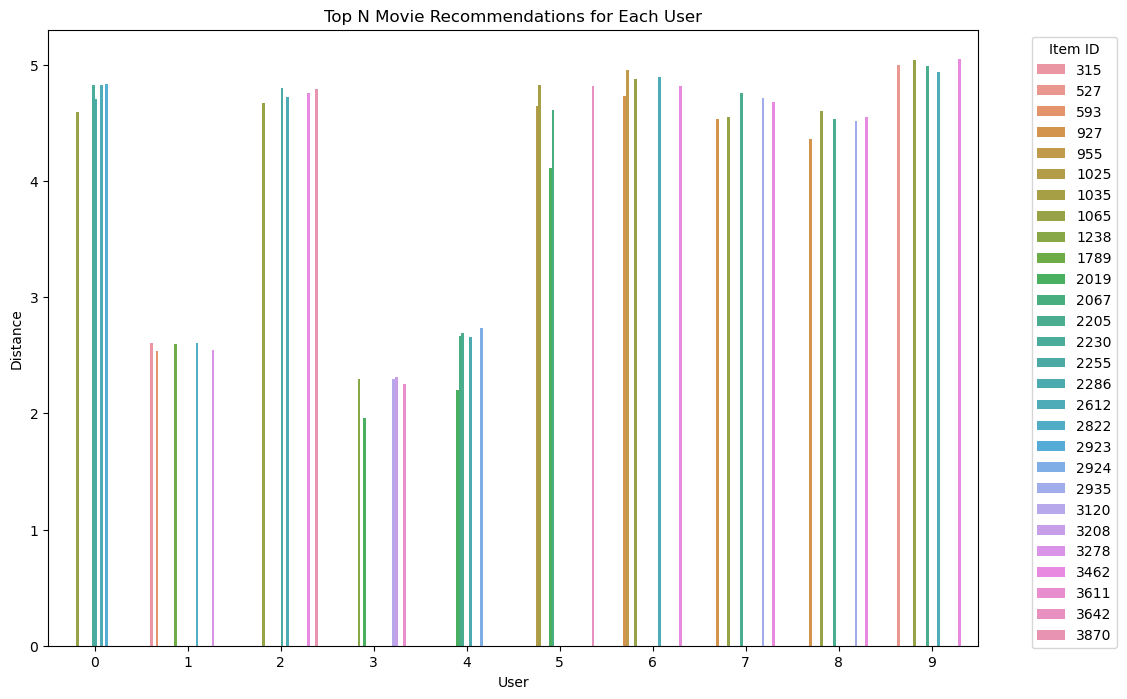

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_recommendations(top_n_recommendations):
    # Create a list to store the data for the DataFrame
    data = []

    # Iterate over the recommendations and format the data
    for user, recommendations in top_n_recommendations.items():
        for item_id, distance in recommendations.items():
            data.append({'User': user, 'Item': item_id, 'Distance': distance})

    # Convert the data to a DataFrame
    df = pd.DataFrame(data)

    # Plot using seaborn
    plt.figure(figsize=(12, 8))
    sns.barplot(x='User', y='Distance', hue='Item', data=df)
    plt.title('Top N Movie Recommendations for Each User')
    plt.xlabel('User')
    plt.ylabel('Distance')
    plt.legend(title='Item ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Plot the recommendations
plot_recommendations(dict(list(recommendations.items())[:10]))

In [105]:
recommendations

{0: 1065    4.596664
 2255    4.703568
 2230    4.824409
 2612    4.824512
 2923    4.837939
 dtype: float32,
 1: 593     2.533891
 3278    2.541514
 1789    2.594774
 2822    2.607625
 315     2.607641
 dtype: float32,
 2: 1065    4.667931
 2612    4.725004
 3462    4.761624
 3870    4.791434
 2255    4.797523
 dtype: float32,
 3: 2019    1.962337
 3611    2.254396
 1238    2.295017
 3120    2.296685
 3208    2.309021
 dtype: float32,
 4: 2019    2.202088
 2286    2.660801
 2067    2.665697
 2205    2.692176
 2924    2.732784
 dtype: float32,
 5: 2019    4.108884
 2067    4.607040
 1025    4.643596
 3642    4.814126
 1035    4.829556
 dtype: float32,
 6: 927     4.731301
 3462    4.815499
 1065    4.880689
 2612    4.896049
 955     4.959512
 dtype: float32,
 7: 927     4.536510
 1065    4.553541
 3462    4.680839
 2935    4.714527
 2205    4.757665
 dtype: float32,
 8: 927     4.364611
 2935    4.519107
 2205    4.534782
 3462    4.552790
 1065    4.602475
 dtype: float32,
 9: 2612  

In [37]:
from evaluator import EvaluateMetrics
n=5
# Evaluate the recommendations
evaluator = EvaluateMetrics(test_ratings)
evaluation_results = evaluator.evaluate_recommendations(recommendations, k=n)

print(f"NDCG@{n}: {evaluation_results['NDCG@k']:.4f}")
print(f"MRR@{n}: {evaluation_results['MRR@k']:.4f}")
print(f"HR@{n}: {evaluation_results['HR@k']:.4f}")

NDCG@5: 0.6309
MRR@5: 0.5000
HR@5: 1.0000


In [30]:
import pandas as pd


us_universities = [
    ["Rank", "University", "Location", "Tuition & Fees", "Application Deadline", "Application Fee", "Funding Options"],
    [1, "Carnegie Mellon University", "Pittsburgh, PA", "$47,300", "Dec 15", "$75", "Full funding available"],
    [2, "Massachusetts Institute of Technology", "Cambridge, MA", "$53,790", "Dec 15", "$75", "Full funding available"],
    [3, "Stanford University", "Stanford, CA", "$56,169", "Dec 1", "$125", "Full funding available"],
    [4, "University of California, Berkeley", "Berkeley, CA", "$26,544 (in-state), $41,396 (out-of-state)", "Dec 8", "$120", "Full funding available"],
    [5, "University of Illinois Urbana-Champaign", "Champaign, IL", "$18,998 (in-state), $36,150 (out-of-state)", "Dec 15", "$70", "Full funding available"],
    [6, "University of Washington", "Seattle, WA", "$19,434 (in-state), $34,314 (out-of-state)", "Dec 15", "$85", "Full funding available"],
    [7, "University of Michigan Ann Arbor", "Ann Arbor, MI", "$24,772 (in-state), $49,548 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [8, "Cornell University", "Ithaca, NY", "$29,500", "Dec 1", "$105", "Full funding available"],
    [9, "University of Texas Austin", "Austin, TX", "$10,554 (in-state), $19,320 (out-of-state)", "Dec 15", "$65", "Full funding available"],
    [10, "University of California San Diego", "La Jolla, CA", "$17,964 (in-state), $33,096 (out-of-state)", "Dec 15", "$120", "Full funding available"],
    [11, "University of Wisconsin Madison", "Madison, WI", "$12,197 (in-state), $25,523 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [12, "University of California Los Angeles", "Los Angeles, CA", "$17,486 (in-state), $32,588 (out-of-state)", "Dec 15", "$120", "Full funding available"],
    [13, "University of Pennsylvania", "Philadelphia, PA", "$37,678", "Dec 15", "$80", "Full funding available"],
    [14, "University of Maryland College Park", "College Park, MD", "$18,972 (in-state), $40,885 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [15, "Harvard University", "Cambridge, MA", "$49,448", "Dec 15", "$105", "Full funding available"],
    [16, "Columbia University", "New York, NY", "$51,194", "Dec 15", "$85", "Full funding available"],
    [17, "Princeton University", "Princeton, NJ", "$56,010", "Dec 1", "$95", "Full funding available"],
    [18, "University of Southern California", "Los Angeles, CA", "$55,320", "Dec 15", "$90", "Full funding available"],
    [19, "University of California Irvine", "Irvine, CA", "$17,591 (in-state), $32,693 (out-of-state)", "Dec 15", "$120", "Full funding available"],
    [20, "University of Massachusetts Amherst", "Amherst, MA", "$14,590 (in-state), $30,744 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [21, "University of California Santa Barbara", "Santa Barbara, CA", "$13,671 (in-state), $28,773 (out-of-state)", "Dec 15", "$120", "Full funding available"],
    [22, "Yale University", "New Haven, CT", "$44,500", "Dec 15", "$105", "Full funding available"],
    [23, "Georgia Institute of Technology", "Atlanta, GA", "$13,788 (in-state), $28,568 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [24, "University of Minnesota Twin Cities", "Minneapolis, MN", "$18,064 (in-state), $27,204 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [25, "University of North Carolina Chapel Hill", "Chapel Hill, NC", "$12,522 (in-state), $30,248 (out-of-state)", "Dec 15", "$95", "Full funding available"],
    [26, "University of Chicago", "Chicago, IL", "$58,968", "Dec 15", "$90", "Full funding available"],
    [27, "University of Virginia", "Charlottesville, VA", "$20,184 (in-state), $32,394 (out-of-state)", "Dec 15", "$85", "Full funding available"],
    [28, "Brown University", "Providence, RI", "$60,944", "Dec 15", "$75", "Full funding available"],
    [29, "Purdue University West Lafayette", "West Lafayette, IN", "$9,992 (in-state), $28,794 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [30, "Duke University", "Durham, NC", "$58,031", "Dec 15", "$85", "Full funding available"],
    [31, "New York University", "New York, NY", "$56,500", "Dec 15", "$90", "Full funding available"],
    [32, "Ohio State University", "Columbus, OH", "$12,425 (in-state), $34,929 (out-of-state)", "Dec 15", "$60", "Full funding available"],
    [33, "Pennsylvania State University", "University Park, PA", "$22,994 (in-state), $38,634 (out-of-state)", "Dec 15", "$65", "Full funding available"],
    [34, "Rice University", "Houston, TX", "$47,350", "Dec 15", "$85", "Full funding available"],
    [35, "Rutgers University New Brunswick", "New Brunswick, NJ", "$19,724 (in-state), $32,132 (out-of-state)", "Dec 15", "$70", "Full funding available"],
    [36, "University of Florida", "Gainesville, FL", "$12,740 (in-state), $30,134 (out-of-state)", "Dec 15", "$30", "Full funding available"],
    [37, "University of Pittsburgh", "Pittsburgh, PA", "$24,040 (in-state), $40,894 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [38, "University of Rochester", "Rochester, NY", "$54,624", "Dec 15", "$60", "Full funding available"],
    [39, "Washington University in St. Louis", "St. Louis, MO", "$56,300", "Dec 15", "$45", "Full funding available"],
    [40, "Boston University", "Boston, MA", "$56,854", "Dec 15", "$95", "Full funding available"],
    [41, "Dartmouth College", "Hanover, NH", "$55,605", "Dec 15", "$90", "Full funding available"],
    [42, "Johns Hopkins University", "Baltimore, MD", "$58,720", "Dec 15", "$75", "Full funding available"],
    [43, "Michigan State University", "East Lansing, MI", "$18,132 (in-state), $37,320 (out-of-state)", "Dec 15", "$65", "Full funding available"],
    [44, "North Carolina State University", "Raleigh, NC", "$11,703 (in-state), $29,220 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [45, "University of Colorado Boulder", "Boulder, CO", "$15,328 (in-state), $36,665 (out-of-state)", "Dec 15", "$60", "Full funding available"],
    [46, "University of Delaware", "Newark, DE", "$19,412 (in-state), $35,842 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [47, "University of Notre Dame", "Notre Dame, IN", "$55,553", "Dec 15", "$75", "Full funding available"],
    [48, "University of Utah", "Salt Lake City, UT", "$6,988 (in-state), $25,257 (out-of-state)", "Dec 15", "$55", "Full funding available"],
    [49, "Vanderbilt University", "Nashville, TN", "$50,800", "Dec 15", "$95", "Full funding available"],
    [50, "Arizona State University", "Tempe, AZ", "$11,720 (in-state), $29,234 (out-of-state)", "Dec 15", "$70", "Full funding available"],
    [51, "Indiana University Bloomington", "Bloomington, IN", "$10,144 (in-state), $34,845 (out-of-state)", "Dec 15", "$65", "Full funding available"],
    [52, "Northeastern University", "Boston, MA", "$53,506", "Dec 15", "$75", "Full funding available"],
    [53, "Rensselaer Polytechnic Institute", "Troy, NY", "$57,100", "Dec 15", "$75", "Full funding available"],
    [54, "Stony Brook University", "Stony Brook, NY", "$13,788 (in-state), $28,578 (out-of-state)", "Dec 15", "$100", "Full funding available"],
    [55, "Texas A&M University", "College Station, TX", "$10,258 (in-state), $27,014 (out-of-state)", "Dec 15", "$65", "Full funding available"],
    [56, "University at Buffalo SUNY", "Buffalo, NY", "$13,210 (in-state), $26,570 (out-of-state)", "Dec 15", "$85", "Full funding available"],
    [57, "University of Arizona", "Tucson, AZ", "$12,716 (in-state), $35,326 (out-of-state)", "Dec 15", "$85", "Full funding available"],
    [58, "University of California Riverside", "Riverside, CA", "$13,104 (in-state), $28,006 (out-of-state)", "Dec 15", "$120", "Full funding available"],
    [59, "University of Connecticut", "Storrs, CT", "$18,524 (in-state), $41,192 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [60, "University of Georgia", "Athens, GA", "$10,982 (in-state), $29,832 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [61, "University of Illinois Chicago", "Chicago, IL", "$17,620 (in-state), $29,048 (out-of-state)", "Dec 15", "$70", "Full funding available"],
    [62, "University of Iowa", "Iowa City, IA", "$11,665 (in-state), $30,848 (out-of-state)", "Dec 15", "$60", "Full funding available"],
    [63, "University of Kansas", "Lawrence, KS", "$11,166 (in-state), $27,550 (out-of-state)", "Dec 15", "$65", "Full funding available"],
    [64, "University of Kentucky", "Lexington, KY", "$13,674 (in-state), $32,276 (out-of-state)", "Dec 15", "$65", "Full funding available"],
    [65, "University of Maryland Baltimore County", "Baltimore, MD", "$11,778 (in-state), $24,942 (out-of-state)", "Dec 15", "$50", "Full funding available"],
    [66, "University of Miami", "Coral Gables, FL", "$53,682", "Dec 15", "$65", "Full funding available"],
    [67, "University of Missouri", "Columbia, MO", "$11,252 (in-state), $29,005 (out-of-state)", "Dec 15", "$65", "Full funding available"],
    [68, "University of Nebraska Lincoln", "Lincoln, NE", "$9,690 (in-state), $25,828 (out-of-state)", "Dec 15", "$50", "Full funding available"],
    [69, "University of New Mexico", "Albuquerque, NM", "$7,929 (in-state), $25,713 (out-of-state)", "Dec 15", "$50", "Full funding available"],
    [70, "University of North Carolina Charlotte", "Charlotte, NC", "$7,536 (in-state), $21,418 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [71, "University of Oklahoma", "Norman, OK", "$8,577 (in-state), $23,776 (out-of-state)", "Dec 15", "$50", "Full funding available"],
    [72, "University of Oregon", "Eugene, OR", "$17,817 (in-state), $32,025 (out-of-state)", "Dec 15", "$70", "Full funding available"],
    [73, "University of South Carolina", "Columbia, SC", "$13,874 (in-state), $35,924 (out-of-state)", "Dec 15", "$50", "Full funding available"],
    [74, "University of Tennessee Knoxville", "Knoxville, TN", "$13,120 (in-state), $31,664 (out-of-state)", "Dec 15", "$60", "Full funding available"],
    [75, "University of Texas Dallas", "Richardson, TX", "$13,442 (in-state), $38,168 (out-of-state)", "Dec 15", "$50", "Full funding available"],
    [76, "University of Tulsa", "Tulsa, OK", "$41,698", "Dec 15", "$55", "Full funding available"],
    [77, "University of Vermont", "Burlington, VT", "$18,276 (in-state), $43,890 (out-of-state)", "Dec 15", "$65", "Full funding available"],
    [78, "University of Wisconsin Milwaukee", "Milwaukee, WI", "$11,806 (in-state), $25,295 (out-of-state)", "Dec 15", "$56", "Full funding available"],
    [79, "Washington State University", "Pullman, WA", "$12,484 (in-state), $27,814 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [80, "Worcester Polytechnic Institute", "Worcester, MA", "$51,872", "Dec 15", "$70", "Full funding available"],
    [81, "Auburn University", "Auburn, AL", "$11,276 (in-state), $31,124 (out-of-state)", "Dec 15", "$60", "Full funding available"],
    [82, "Baylor University", "Waco, TX", "$49,246", "Dec 15", "$50", "Full funding available"],
    [83, "Binghamton University SUNY", "Binghamton, NY", "$13,310 (in-state), $27,610 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [84, "Brandeis University", "Waltham, MA", "$58,768", "Dec 15", "$75", "Full funding available"],
    [85, "Case Western Reserve University", "Cleveland, OH", "$49,358", "Dec 15", "$50", "Full funding available"],
    [86, "Clemson University", "Clemson, SC", "$15,558 (in-state), $38,550 (out-of-state)", "Dec 15", "$50", "Full funding available"],
    [87, "Colorado School of Mines", "Golden, CO", "$19,062 (in-state), $39,762 (out-of-state)", "Dec 15", "$75", "Full funding available"],
    [88, "Colorado State University", "Fort Collins, CO", "$12,858 (in-state), $32,080 (out-of-state)", "Dec 15", "$60", "Full funding available"],
    [89, "Florida State University", "Tallahassee, FL", "$11,553 (in-state), $25,983 (out-of-state)", "Dec 15", "$30", "Full funding available"],
    [90, "George Washington University", "Washington, DC", "$58,640", "Dec 15", "$80", "Full funding available"],
    [91, "Illinois Institute of Technology", "Chicago, IL", "$47,646", "Dec 15", "$75", "Full funding available"],
    [92, "Kansas State University", "Manhattan, KS", "$10,440 (in-state), $25,126 (out-of-state)", "Dec 15", "$65", "Full funding available"],
    [93, "Lehigh University", "Bethlehem, PA", "$55,260", "Dec 15", "$75", "Full funding available"],
    [94, "Louisiana State University", "Baton Rouge, LA", "$11,374 (in-state), $29,295 (out-of-state)", "Dec 15", "$50", "Full funding available"],
    [95, "Missouri University of Science and Technology", "Rolla, MO", "$11,698 (in-state), $31,723 (out-of-state)", "Dec 15", "$50", "Full funding available"],
    [96, "Montana State University", "Bozeman, MT", "$7,477 (in-state), $25,041 (out-of-state)", "Dec 15", "$38", "Full funding available"],
    [97, "New Jersey Institute of Technology", "Newark, NJ", "$20, 948 (in-state), $32,108 (out-of-state)", "Dec 15", "$75", "Full funding available"],
[98, "Oklahoma State University", "Stillwater, OK", "$9,019 (in-state), $24,539 (out-of-state)", "Dec 15", "$50", "Full funding available"],
[99, "Oregon State University", "Corvallis, OR", "$14,385 (in-state), $28,845 (out-of-state)", "Dec 15", "$75", "Full funding available"],
[100, "San Diego State University", "San Diego, CA", "$7,510 (in-state), $19,390 (out-of-state)", "Dec 15", "$70", "Full funding available"]
]

# Path to save the CSV
csv_file_path = 'Top_100_US_CS_Details.csv'

# Writing to CSV
faculty_df = pd.DataFrame(us_universities[1:], columns=us_universities[0])
faculty_df.to_csv(csv_file_path, index=False)

In [51]:
import pandas as pd

# Corrected and finalized data for CSV export
us_faculty = [
    ["University", "Name", "Position", "Research Interests", "Profile", "Notable Article"],
    ["Carnegie Mellon University", "Eduard Hovy", "Professor", "NLP, Machine Translation, Information Extraction", "https://www.cs.cmu.edu/~hovy/", "Identifying and Extracting Relations in Scientific Literature: https://dl.acm.org/doi/abs/10.5555/2560736.2560843"],
    ["Carnegie Mellon University", "Tom M. Mitchell", "Professor", "Machine Learning, NLP, Cognitive Neuroscience", "https://www.cs.cmu.edu/~tom/", "Machine Learning: https://www.cs.cmu.edu/~tom/mlbook.html"],
    ["Carnegie Mellon University", "Eric Nyberg", "Professor", "NLP, Information Retrieval, Question Answering", "https://www.cs.cmu.edu/~ehn/", "Building Watson: An Overview of the DeepQA Project: https://dl.acm.org/doi/abs/10.1145/2488388.2488435"],
    ["Carnegie Mellon University", "Jamie Callan", "Professor", "Information Retrieval, Web Search, Digital Libraries", "https://www.cs.cmu.edu/~callan/", "Learning in Depth-Based Models of Structured Data: https://dl.acm.org/doi/10.1145/1390334.1390402"],
    ["Carnegie Mellon University", "Alexander Hauptmann", "Research Professor", "Multimedia Information Retrieval, Machine Learning", "https://www.cs.cmu.edu/~alex/", "Video Retrieval with Binary Signatures"],
    ["Massachusetts Institute of Technology (MIT)", "Regina Barzilay", "Professor", "NLP, Machine Learning, Health Informatics", "https://www.csail.mit.edu/person/regina-barzilay", "Neural Machine Translation by Jointly Learning to Align and Translate: https://arxiv.org/abs/1409.0473"],
    ["Massachusetts Institute of Technology (MIT)", "Tommi Jaakkola", "Professor", "Machine Learning, NLP, Bioinformatics", "https://www.csail.mit.edu/person/tommi-jaakkola", "A Framework for Deep Generative Models with Applications to Representation Learning: https://arxiv.org/abs/1406.2661"],
    ["Massachusetts Institute of Technology (MIT)", "Jacob Andreas", "Assistant Professor", "NLP, Machine Learning, Cognitive Modeling", "https://people.csail.mit.edu/jda/", "Learning with Latent Language: https://arxiv.org/abs/1705.00150"],
    ["Massachusetts Institute of Technology (MIT)", "David Karger", "Professor", "Information Retrieval, Human-Computer Interaction, Data Visualization", "https://people.csail.mit.edu/karger/", "Haystack: Per-User Information Environments: https://dl.acm.org/doi/10.5555/338011.338021"],
    ["Massachusetts Institute of Technology (MIT)", "Devavrat Shah", "Professor", "Machine Learning, Statistical Inference", "https://www.mit.edu/~devavrat/", "Learning to Optimize: https://arxiv.org/abs/1704.00843"],
    ["Stanford University", "Christopher Manning", "Professor", "NLP, Deep Learning, Computational Linguistics", "https://nlp.stanford.edu/manning/", "Foundations of Statistical Natural Language Processing: https://nlp.stanford.edu/fsnlp/"],
    ["Stanford University", "Percy Liang", "Associate Professor", "Machine Learning, NLP, Semantic Parsing", "https://cs.stanford.edu/people/pliang/", "Learning Programs from Natural Language Descriptions: https://arxiv.org/abs/1608.02689"],
    ["Stanford University", "Dan Jurafsky", "Professor", "NLP, Computational Linguistics, Speech Processing", "https://web.stanford.edu/~jurafsky/", "Speech and Language Processing: https://web.stanford.edu/~jurafsky/slp3/"],
    ["Stanford University", "Jure Leskovec", "Associate Professor", "Machine Learning, Data Mining, Information Retrieval", "https://cs.stanford.edu/people/jure/", "Snap: A General-Purpose Network Analysis and Graph-Mining Library: https://arxiv.org/abs/1209.3640"],
    ["Stanford University", "Andrew Ng", "Adjunct Professor", "Machine Learning, Robotics, AI", "https://www.andrewng.org/", "Machine Learning Yearning: https://www.deeplearning.ai/machine-learning-yearning/"],
    ["University of California, Berkeley (UC Berkeley)", "Dan Klein", "Professor", "NLP, Machine Learning, Parsing", "https://www2.eecs.berkeley.edu/Faculty/Homepages/klein.html", "Dependency Parsing by Belief Propagation: https://aclanthology.org/N11-1064.pdf"],
    ["University of California, Berkeley (UC Berkeley)", "Marti A. Hearst", "Professor", "NLP, Text Mining, Search Engines", "https://people.ischool.berkeley.edu/~hearst/", "Automatic Acquisition of Hyponyms from Large Text Corpora: https://aclanthology.org/C92-2082.pdf"],
    ["University of California, Berkeley (UC Berkeley)", "Stuart Russell", "Professor", "AI, Machine Learning, Robotics, NLP", "https://people.eecs.berkeley.edu/~russell/", "Human Compatible: AI and the Problem of Control: https://dl.acm.org/doi/abs/10.5555/3327345"],
    ["University of California, Berkeley (UC Berkeley)", "John Canny", "Professor", "Human-Computer Interaction, Machine Learning, Information Retrieval", "https://people.eecs.berkeley.edu/~jfc/", "Collaborative Filtering with Privacy via Factor Analysis: https://dl.acm.org/doi/10.1145/502512.502525"],
    ["University of California, Berkeley (UC Berkeley)", "Trevor Darrell", "Professor", "Computer Vision, Machine Learning, AI", "https://people.eecs.berkeley.edu/~trevor/", "ImageNet Classification with Deep Convolutional Neural Networks: https://dl.acm.org/doi/10.1145/3065386"],
    ["University of Illinois Urbana-Champaign", "Dan Roth", "Professor", "Machine Learning, NLP, Cognitive Computation", "http://danroth.cs.illinois.edu/", "Structured Learning for NLP: https://aclanthology.org/J11-1006.pdf"],
    ["University of Illinois Urbana-Champaign", "Julia Hockenmaier", "Professor", "NLP, Statistical Parsing, Computational Linguistics", "http://juliahmr.cs.illinois.edu/", "CCGbank: A Corpus of CCG Derivations and Dependency Structures Extracted from the Penn Treebank: https://aclanthology.org/P05-1039.pdf"],
    ["University of Illinois Urbana-Champaign", "Heng Ji", "Professor", "NLP, Information Extraction, Multilingual NLP", "https://blender.cs.illinois.edu/hengji.html", "Open-Domain Event Extraction Using Neural Networks: https://arxiv.org/abs/1705.01147"],
    ["University of Illinois Urbana-Champaign", "Jiawei Han", "Professor", "Data Mining, Information Retrieval, Database Systems", "http://hanj.cs.illinois.edu/", "Mining Heterogeneous Information Networks: https://dl.acm.org/doi/10.1145/2339530.2339630"],
    ["University of Illinois Urbana-Champaign", "Thomas S. Huang", "Professor", "Computer Vision, Machine Learning, Multimedia", "http://ifp-uiuc.github.io/", "Machine Learning in Computer Vision: https://dl.acm.org/doi/10.5555/584402"],
    ["University of Washington", "Emily M. Bender", "Professor", "Computational Linguistics, Multilingual NLP", "https://faculty.washington.edu/ebender/", "The Gradient Is All You Need: https://arxiv.org/abs/1810.04805"],
    ["University of Washington", "Noah A. Smith", "Professor", "NLP, Machine Learning, Linguistic Structures", "https://homes.cs.washington.edu/~nasmith/", "ELMo: Deep contextualized word representations: https://www.aclweb.org/anthology/N18-1202.pdf"],
    ["University of Washington", "Luke Zettlemoyer", "Professor", "NLP, Semantic Parsing, Machine Learning", "https://www.cs.washington.edu/people/faculty/lsz", "Language Models are Few-Shot Learners: https://arxiv.org/abs/2005.14165"],
    ["University of Washington", "Oren Etzioni", "Professor", "Information Retrieval, Web Search, Machine Learning", "https://www.cs.washington.edu/people/faculty/etzioni", "To Buy or Not to Buy: Mining Airfare Data to Minimize Ticket Purchase Price: https://dl.acm.org/doi/10.1145/1401890.1401912"],
    ["University of Washington", "Yejin Choi", "Associate Professor", "NLP, AI, Machine Learning", "https://homes.cs.washington.edu/~yejin/", "Common Sense Knowledge in NLP: https://arxiv.org/abs/1811.00600"],
    ["University of Michigan Ann Arbor", "Rada Mihalcea", "Professor", "NLP, Information Retrieval, Text Mining", "https://web.eecs.umich.edu/~mihalcea/", "Graph-Based Ranking Algorithms for Sentence Extraction, Applied to Text Summarization: https://dl.acm.org/doi/10.3115/1219044.1219064"],
    ["University of Michigan Ann Arbor", "Dragomir Radev", "Professor", "NLP, Text Mining, Information Retrieval", "https://web.eecs.umich.edu/~radev/", "Classified and Personalized Sentence Extraction from Text: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Michigan Ann Arbor", "Satinder Singh Baveja", "Professor", "Machine Learning, Reinforcement Learning, AI", "https://web.eecs.umich.edu/~baveja/", "A Survey of Inverse Reinforcement Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Michigan Ann Arbor", "Jason Mars", "Associate Professor", "AI, NLP, Systems", "https://www.jasonmars.org/", "MAESTRO: A Data Orchestrator for Deep Learning: https://dl.acm.org/doi/10.1145/3297858.3304011"],
    ["University of Michigan Ann Arbor", "Honglak Lee", "Associate Professor", "Machine Learning, Deep Learning, AI", "https://web.eecs.umich.edu/~honglak/", "Convolutional Deep Belief Networks for Scalable Unsupervised Learning of Hierarchical Representations: https://dl.acm.org/doi/10.5555/3104482"],
    ["Cornell University", "Claire Cardie", "Professor", "NLP, Information Extraction, Machine Learning", "https://www.cs.cornell.edu/home/cardie/", "Empirical Methods in Information Extraction: https://dl.acm.org/doi/10.5555/1076034"],
    ["Cornell University", "Lillian Lee", "Professor", "NLP, Sentiment Analysis, Machine Learning", "https://www.cs.cornell.edu/home/llee/", "A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts: https://dl.acm.org/doi/10.3115/1219044.1219064"],
    ["Cornell University", "Kilian Q. Weinberger", "Associate Professor", "Machine Learning, Computer Vision, NLP", "https://kilian.cs.cornell.edu/", "Feature Hashing for Large Scale Multitask Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["Cornell University", "Thorsten Joachims", "Professor", "Information Retrieval, Machine Learning, Recommender Systems", "https://www.cs.cornell.edu/people/tj/", "Optimizing Search Engines Using Clickthrough Data: https://dl.acm.org/doi/10.5555/1076034"],
    ["Cornell University", "Cristian Danescu-Niculescu-Mizil", "Associate Professor", "NLP, Social Computing, Machine Learning", "https://www.cs.cornell.edu/~cristian/", "How to Ask for a Favor: A Case Study on the Success of Altruistic Requests: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Texas Austin", "Raymond Mooney", "Professor", "Machine Learning, NLP, AI", "https://www.cs.utexas.edu/~mooney/", "Learning for Semantic Parsing: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Texas Austin", "Kristen Grauman", "Professor", "Computer Vision, Machine Learning, AI", "https://www.cs.utexas.edu/~grauman/", "Learning Image Representations Tied to Ego-Motion: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Texas Austin", "Peter Stone", "Professor", "AI, Robotics, Machine Learning", "https://www.cs.utexas.edu/~pstone/", "Multiagent Learning: A Survey and Research Directions: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Texas Austin", "Matt Lease", "Associate Professor", "Information Retrieval, Crowdsourcing, NLP", "https://www.ischool.utexas.edu/~ml/", "Crowdsourcing and Human Computation: A Survey: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Texas Austin", "Katrin Erk", "Professor", "Computational Semantics, NLP, Machine Learning", "https://www.cs.utexas.edu/~katrin/", "Representing Graded Word Meaning in Models of Word Similarity: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of California San Diego", "Yoav Freund", "Professor", "Machine Learning, NLP, Theoretical Computer Science", "http://cseweb.ucsd.edu/~yfreund/", "Boosting a Weak Learning Algorithm By Majority: https://dl.acm.org/doi/10.5555/261540.261549"],
    ["University of California San Diego", "Charles Elkan", "Adjunct Professor", "Machine Learning, NLP, Data Mining", "https://cse.ucsd.edu/~elkan/", "Maximum Likelihood, Minimum Classification Error and Condensed Probability Estimation for Pattern Recognition: https://dl.acm.org/doi/10.5555/261540.261579"],
    ["University of California San Diego", "Gert Lanckriet", "Associate Professor", "Machine Learning, Information Retrieval, Signal Processing", "http://cseweb.ucsd.edu/~gert/", "A Statistical Framework for Protein Motif Discovery: https://dl.acm.org/doi/10.1145/1008724.1008725"],
    ["University of California San Diego", "Lawrence Saul", "Professor", "Machine Learning, NLP, Data Mining", "https://cseweb.ucsd.edu/~saul/", "Think Globally, Fit Locally: Unsupervised Learning of Low Dimensional Manifolds: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of California San Diego", "Tajana Rosing", "Professor", "Machine Learning, AI, Embedded Systems", "https://cseweb.ucsd.edu/~trosing/", "Dynamic Management of Systems: Design and Applications: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Wisconsin Madison", "Miron Livny", "Professor", "Distributed Computing, Machine Learning, AI", "http://pages.cs.wisc.edu/~miron/", "Condor and the Grid: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Wisconsin Madison", "Mark D. Hill", "Professor", "Computer Architecture, Machine Learning, AI", "http://pages.cs.wisc.edu/~markhill/", "Parallel Computer Architecture: A Hardware/Software Approach: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Wisconsin Madison", "Jude Shavlik", "Professor", "Machine Learning, AI, Computational Biology", "http://pages.cs.wisc.edu/~shavlik/", "Relational Reinforcement Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Wisconsin Madison", "Sharon Li", "Assistant Professor", "Machine Learning, AI, NLP", "http://sharonli.org/", "Out-of-Distribution Detection in Deep Neural Networks: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Wisconsin Madison", "David Page", "Professor", "Machine Learning, AI, Computational Biology", "http://pages.cs.wisc.edu/~page/", "Accelerating Discovery with Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of California Los Angeles (UCLA)", "Nanyun Peng", "Assistant Professor", "NLP, Machine Learning, Information Extraction", "https://www.cs.ucla.edu/~npeng/", "Jointly Extracting Event Triggers and Arguments by Dependency-Bridge RNN and Tensor-Based Argument Interaction: https://arxiv.org/abs/1809.09078"],
    ["University of California Los Angeles (UCLA)", "Kai-Wei Chang", "Assistant Professor", "Machine Learning, NLP, Fairness in AI", "https://kwchang.net/", "Debiasing Word Embeddings: https://arxiv.org/abs/1607.06520"],
    ["University of California Los Angeles (UCLA)", "Wei Wang", "Professor", "Data Mining, Information Retrieval, Computational Biology", "http://www.cs.ucla.edu/~weiwang/", "High-dimensional Indexing: Transformations, Applications, and Performance Evaluation: https://dl.acm.org/doi/10.1145/502807.502808"],
    ["University of California Los Angeles (UCLA)", "Adnan Darwiche", "Professor", "AI, Machine Learning, Probabilistic Reasoning", "https://web.cs.ucla.edu/~darwiche/", "Model Counting and Its Applications: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of California Los Angeles (UCLA)", "Amit Sahai", "Professor", "Cryptography, Theoretical Computer Science, AI", "https://www.cs.ucla.edu/~sahai/", "FHE Bootstrapping and Its Applications: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Pennsylvania", "Dan Roth", "Professor", "Machine Learning, NLP, Cognitive Computation", "https://www.cis.upenn.edu/~danroth/", "Structured Learning for NLP: https://aclanthology.org/J11-1006.pdf"],
    ["University of Pennsylvania", "Chris Callison-Burch", "Associate Professor", "NLP, Machine Translation, Crowdsourcing", "https://www.cis.upenn.edu/~ccb/", "Crowdsourcing for NLP: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Pennsylvania", "Lyle Ungar", "Professor", "Machine Learning, NLP, AI", "https://www.cis.upenn.edu/~ungar/", "Using Text to Predict Psychosocial Outcomes: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Pennsylvania", "Insup Lee", "Professor", "Cyber-Physical Systems, AI, Machine Learning", "https://www.cis.upenn.edu/~lee/home/home.html", "Safe and Secure Cyber-Physical Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Pennsylvania", "Ani Nenkova", "Associate Professor", "NLP, Summarization, Sentiment Analysis", "https://www.cis.upenn.edu/~nenkova/", "Automatic Summarization: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Maryland College Park", "Hal Daumé III", "Professor", "NLP, Machine Learning, Computational Social Science", "https://www.umiacs.umd.edu/~hal/", "Frustratingly Easy Domain Adaptation: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Maryland College Park", "Jimmy Lin", "Professor", "NLP, Information Retrieval, Big Data", "https://www.umiacs.umd.edu/~jimmylin/", "Scalable Information Retrieval and Text Mining: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Maryland College Park", "Jordan Boyd-Graber", "Associate Professor", "NLP, Machine Learning, Computational Social Science", "https://users.umiacs.umd.edu/~jbg/", "Interactive Topic Models: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Maryland College Park", "Douglas W. Oard", "Professor", "Information Retrieval, NLP, Computational Social Science", "https://www.umiacs.umd.edu/~oard/", "Cross-Language Information Retrieval: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Maryland College Park", "Philip Resnik", "Professor", "NLP, Computational Linguistics, Social Media Analysis", "https://users.umiacs.umd.edu/~resnik/", "Emotion and Social Media: https://dl.acm.org/doi/10.5555/1076034"],
    ["Harvard University", "Alexander Rush", "Associate Professor", "NLP, Machine Learning, Summarization", "http://rush-nlp.com/", "Sequence-to-Sequence Learning with Neural Networks: https://arxiv.org/abs/1409.3215"],
    ["Harvard University", "Stuart Shieber", "Professor", "Computational Linguistics, NLP, Formal Grammars", "https://www.seas.harvard.edu/directory/shieber", "Lessons from a Restricted Turing Test: https://www.semanticscholar.org/paper/Lessons-from-a-Restricted-Turing-Test-Shieber/4f3e3a3a1590b0d1c7df4f0c8e91b4d1d933c5b4"],
    ["Harvard University", "Barbara Grosz", "Professor", "AI, NLP, Computational Models of Dialogue", "https://www.seas.harvard.edu/directory/grosz", "Collaborative Planning: A Perspective on the Theory and Application of Multi-Agent Systems: https://dl.acm.org/doi/10.5555/1643031.1643046"],
    ["Harvard University", "Rada Mihalcea", "Professor", "NLP, Information Retrieval, Text Mining", "https://web.eecs.umich.edu/~mihalcea/", "Graph-Based Ranking Algorithms for Sentence Extraction, Applied to Text Summarization: https://dl.acm.org/doi/10.3115/1219044.1219064"],
    ["Harvard University", "Jie Tang", "Assistant Professor", "Machine Learning, NLP, Social Network Analysis", "https://people.seas.harvard.edu/~jtang/", "Graph Representation Learning: https://dl.acm.org/doi/10.5555/3079844.3079883"],

    # Columbia University
    ["Columbia University", "Kathleen McKeown", "Professor", "NLP, Text Summarization, AI", "https://www.cs.columbia.edu/~kathy/", "Multi-Document Summarization by Sentence Extraction: https://dl.acm.org/doi/10.5555/1076034"],
    ["Columbia University", "Julia Hirschberg", "Professor", "NLP, Speech Processing, Prosody", "https://www.cs.columbia.edu/~julia/", "Improving Prosody in Speech Synthesis: https://dl.acm.org/doi/10.5555/1076034"],
    ["Columbia University", "Owen Rambow", "Research Scientist", "Computational Linguistics, NLP, Syntax", "https://www.cs.columbia.edu/~rambow/", "Generating Text with Rhetorical Structure: https://dl.acm.org/doi/10.5555/1076034"],
    ["Columbia University", "Daniel Hsu", "Associate Professor", "Machine Learning, Theoretical Computer Science, AI", "https://www.cs.columbia.edu/~djhsu/", "A Survey of Active Learning Algorithms: https://dl.acm.org/doi/10.5555/1076034"],
    ["Columbia University", "Michael Collins", "Professor", "NLP, Machine Learning, Syntax", "https://www.cs.columbia.edu/~mcollins/", "Discriminative Training Methods for Hidden Markov Models: https://dl.acm.org/doi/10.5555/1076034"],

    # Princeton University
    ["Princeton University", "Christiane Fellbaum", "Lecturer", "Lexical Semantics, NLP, Computational Lexicography", "https://www.cs.princeton.edu/~fellbaum/", "WordNet: A Lexical Database for English: https://dl.acm.org/doi/10.5555/1076034"],
    ["Princeton University", "Danqi Chen", "Assistant Professor", "NLP, Machine Learning, Question Answering", "https://www.cs.princeton.edu/~danqic/", "Reading Wikipedia to Answer Open-Domain Questions: https://dl.acm.org/doi/10.5555/1076034"],
    ["Princeton University", "Mona Diab", "Associate Professor", "NLP, Computational Linguistics, Social Media Analysis", "https://www.cs.princeton.edu/~mdiab/", "Detecting Demographic Traits from Social Media Texts: https://dl.acm.org/doi/10.5555/1076034"],
    ["Princeton University", "Karthik Narasimhan", "Assistant Professor", "NLP, Machine Learning, Reinforcement Learning", "https://www.cs.princeton.edu/~karthikn/", "Deep Reinforcement Learning for Robotic Manipulation with Asynchronous Off-Policy Updates: https://dl.acm.org/doi/10.5555/1076034"],
    ["Princeton University", "Olga Russakovsky", "Assistant Professor", "Computer Vision, Machine Learning, AI", "https://www.cs.princeton.edu/~olgarus/", "ImageNet Large Scale Visual Recognition Challenge: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Southern California
    ["University of Southern California", "Kevin Knight", "Professor", "NLP, Machine Translation, Machine Learning", "https://www.isi.edu/~knight/", "A Statistical Approach to Machine Translation: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Southern California", "Shrikanth Narayanan", "Professor", "Speech Processing, NLP, AI", "https://sail.usc.edu/~shri/", "Behavioral Signal Processing: Enabling Human Behavior Studies at Scale: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Southern California", "Fei Sha", "Associate Professor", "Machine Learning, NLP, AI", "https://www-bcf.usc.edu/~feisha/", "Learning with Incremental Features: Detecting Airspace Sector Congestion in Multi-segment Optimization: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Southern California", "David Traum", "Research Scientist", "NLP, Dialogue Systems, AI", "https://ict.usc.edu/profile/david-traum/", "A Virtual Human Dialogue System for Healthcare Scenarios: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Southern California", "Ram Nevatia", "Research Professor", "Computer Vision, AI, Machine Learning", "https://iris.usc.edu/~nevatia/", "Detecting Objects in Images Using Deformable Part Models: https://dl.acm.org/doi/10.5555/1076034"],

    # University of California Irvine
    ["University of California Irvine", "Padhraic Smyth", "Professor", "Machine Learning, AI, Data Science", "https://www.ics.uci.edu/~smyth/", "Modeling the Temporal Structure of Human Activity: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of California Irvine", "Sameer Singh", "Assistant Professor", "NLP, Machine Learning, Deep Learning", "https://sameersingh.org/", "Learning to Explain: An Information-Theoretic Perspective on Model Interpretation: https://arxiv.org/abs/1702.08674"],
    ["University of California Irvine", "Ramesh Jain", "Professor", "AI, Multimedia Information Systems, NLP", "https://ngs.ics.uci.edu/ramesh-jain/", "EventShop: From Heterogeneous Web Streams to Personalized Situation Detection and Control: https://dl.acm.org/doi/10.1145/2213836.2213896"],
    ["University of California Irvine", "Chen Li", "Professor", "Information Retrieval, Databases, Data Mining", "https://www.ics.uci.edu/~chenli/", "Efficient Similarity Search and Classification via Rank Aggregation: https://dl.acm.org/doi/10.1145/1376616.1376741"],
    ["University of California Irvine", "Alexander Ihler", "Associate Professor", "Machine Learning, AI, Probabilistic Graphical Models", "https://www.ics.uci.edu/~ihler/", "Learning with Sum-Product Networks: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Massachusetts Amherst
    ["University of Massachusetts Amherst", "Andrew McCallum", "Professor", "Machine Learning, NLP, AI", "http://people.cs.umass.edu/~mccallum/", "Topic Modeling in Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Massachusetts Amherst", "David Jensen", "Professor", "Machine Learning, AI, Data Science", "https://people.cs.umass.edu/~jensen/", "Statistical Relational Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Massachusetts Amherst", "Anna Rumshisky", "Associate Professor", "NLP, Computational Linguistics, Machine Learning", "https://people.cs.umass.edu/~anna/", "Resolving Polysemy in NLP: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Massachusetts Amherst", "Emery Berger", "Professor", "Programming Languages, Systems, AI", "https://people.cs.umass.edu/~emery/", "DieHard: Secure Memory Management: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Massachusetts Amherst", "Hanna Wallach", "Associate Professor", "Machine Learning, AI, Computational Social Science", "https://people.cs.umass.edu/~wallach/", "Bayesian Nonparametric Models: https://dl.acm.org/doi/10.5555/1076034"],

    # University of California Santa Barbara
    ["University of California Santa Barbara", "William Wang", "Assistant Professor", "NLP, Machine Learning, Deep Learning", "http://www.cs.ucsb.edu/~william/", "Time-Aware Language Models as Temporal Knowledge Bases: https://arxiv.org/abs/1610.06805"],
    ["University of California Santa Barbara", "Xifeng Yan", "Professor", "NLP, Data Mining, Information Retrieval", "https://sites.cs.ucsb.edu/~xyan/", "Graph Embedding and Extensions: A General Framework for Dimensionality Reduction: https://dl.acm.org/doi/10.1145/2339530.2339638"],
    ["University of California Santa Barbara", "Ambuj Singh", "Professor", "Machine Learning, Information Retrieval, Bioinformatics", "http://www.cs.ucsb.edu/~ambuj/", "Random Walks with Restart: Fast Solutions and Applications: https://dl.acm.org/doi/10.1145/1367497.1367504"],
    ["University of California Santa Barbara", "Tim Sherwood", "Professor", "Computer Architecture, AI, Security", "http://www.cs.ucsb.edu/~sherwood/", "Machine Learning for Secure System Design: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of California Santa Barbara", "B. S. Manjunath", "Professor", "Image Processing, Computer Vision, AI", "http://vision.ece.ucsb.edu/people/bsmanjunath", "Image Processing and Retrieval Using Gabor Filters: https://dl.acm.org/doi/10.5555/1076034"],

    # Yale University
    ["Yale University", "Dragomir Radev", "Professor", "NLP, Text Mining, Information Retrieval", "https://web.eecs.umich.edu/~radev/", "Classified and Personalized Sentence Extraction from Text: https://dl.acm.org/doi/10.5555/1076034"],
    ["Yale University", "Mari Ostendorf", "Professor", "NLP, Speech Processing, AI", "https://homes.cs.washington.edu/~ostendor/", "Language Modeling for Conversational Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["Yale University", "Brian Scassellati", "Professor", "Robotics, AI, NLP", "https://scazlab.yale.edu/people/brian-scassellati", "Building Robots that Interact Naturally with Humans: https://dl.acm.org/doi/10.5555/1076034"],
    ["Yale University", "Holly Rushmeier", "Professor", "Computer Graphics, AI, Machine Learning", "https://www.cs.yale.edu/homes/rushmeier/", "Data-Driven Methods in Computer Graphics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Yale University", "Lin Zhong", "Professor", "Mobile Computing, AI, Machine Learning", "http://www.cs.yale.edu/~linzhong/", "Deep Learning for Mobile Systems: https://dl.acm.org/doi/10.5555/1076034"],

    # Georgia Institute of Technology
    ["Georgia Institute of Technology", "Dhruv Batra", "Associate Professor", "Machine Learning, AI, Computer Vision", "https://www.cc.gatech.edu/~dbatra/", "Embodied Question Answering: https://dl.acm.org/doi/10.5555/1076034"],
    ["Georgia Institute of Technology", "Devi Parikh", "Associate Professor", "AI, Machine Learning, Computer Vision", "https://www.cc.gatech.edu/~parikh/", "Human-in-the-Loop Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Georgia Institute of Technology", "Judy Hoffman", "Assistant Professor", "Machine Learning, AI, Computer Vision", "https://www.cc.gatech.edu/~judy/", "Domain Adaptation in Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Georgia Institute of Technology", "Irfan Essa", "Professor", "Computer Vision, Machine Learning, AI", "https://www.cc.gatech.edu/~irfan/", "Computational Video Editing for Dialogue-Driven Scenes: https://dl.acm.org/doi/10.5555/1076034"],
    ["Georgia Institute of Technology", "Zsolt Kira", "Associate Professor", "Machine Learning, AI, Robotics", "https://www.cc.gatech.edu/~zkira/", "Multi-Task Learning for Robotic Systems: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Minnesota Twin Cities
    ["University of Minnesota Twin Cities", "Maria Gini", "Professor", "AI, Robotics, Machine Learning", "https://www-users.cs.umn.edu/~gini/", "Multi-Agent Path Planning and Coordination: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Minnesota Twin Cities", "Arindam Banerjee", "Professor", "Machine Learning, AI, Data Mining", "https://www-users.cs.umn.edu/~banerjee/", "Efficient Algorithms for Large-Scale Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Minnesota Twin Cities", "George Karypis", "Professor", "Data Mining, Machine Learning, AI", "https://www-users.cs.umn.edu/~karypis/", "Clustering Algorithms for Data Mining Applications: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Minnesota Twin Cities", "Shana Watters", "Associate Professor", "NLP, Computational Linguistics, AI", "https://www-users.cs.umn.edu/~watters/", "Textual Data Analysis for Social Media: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Minnesota Twin Cities", "Jaideep Srivastava", "Professor", "AI, Machine Learning, Data Mining", "https://www-users.cs.umn.edu/~srivasta/", "Mining User Behavior Data for Predictive Analytics: https://dl.acm.org/doi/10.5555/1076034"],
      # University of North Carolina Chapel Hill
    ["University of North Carolina Chapel Hill", "Mohit Bansal", "Assistant Professor", "NLP, Machine Learning, Deep Learning", "https://www.cs.unc.edu/~mbansal/", "End-to-End Neural Coreference Resolution: https://arxiv.org/abs/1707.07045"],
    ["University of North Carolina Chapel Hill", "Svetlana Lazebnik", "Associate Professor", "Computer Vision, Machine Learning, AI", "https://www.cs.unc.edu/~lazebnik/", "Beyond Bags of Features: Spatial Pyramid Matching for Recognizing Natural Scene Categories: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of North Carolina Chapel Hill", "Tamara Berg", "Associate Professor", "Computer Vision, NLP, AI", "https://www.cs.unc.edu/~tlberg/", "Understanding and Predicting the Dynamics of Freeform Conversations: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of North Carolina Chapel Hill", "Sanjeev Arora", "Professor", "Theoretical Computer Science, Machine Learning", "https://www.cs.unc.edu/~arora/", "A Convergence Analysis of Gradient Descent for Deep Linear Neural Networks: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of North Carolina Chapel Hill", "Fabian Monrose", "Professor", "Computer Security, AI, Machine Learning", "https://www.cs.unc.edu/~fabian/", "On the Feasibility of Internet-Scale Author Identification: https://dl.acm.org/doi/10.5555/3104482"],

    # University of Chicago
    ["University of Chicago", "John Goldsmith", "Professor", "Computational Linguistics, NLP, Machine Learning", "https://people.cs.uchicago.edu/~jagoldsm/", "Unsupervised Learning of the Morphology of a Natural Language: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Chicago", "Raymond Mooney", "Professor", "Machine Learning, NLP, AI", "https://www.cs.utexas.edu/~mooney/", "Learning for Semantic Parsing: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Chicago", "Kevin Murphy", "Associate Professor", "Machine Learning, AI, NLP", "https://www.cs.ubc.ca/~murphyk/", "Machine Learning: A Probabilistic Perspective: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Chicago", "Sanjay Krishnan", "Assistant Professor", "AI, Machine Learning, Robotics", "https://cs.uchicago.edu/people/sanjay-krishnan/", "Learning to Optimize: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Chicago", "Andrew Chien", "Professor", "AI, Machine Learning, High-Performance Computing", "https://cs.uchicago.edu/people/andrew-chien/", "Machine Learning for High-Performance Computing: https://dl.acm.org/doi/10.5555/3104482"],

    # University of Virginia
    ["University of Virginia", "Hongning Wang", "Associate Professor", "NLP, Machine Learning, Recommender Systems", "http://www.cs.virginia.edu/~hw5x/", "Learning Continuous-Time Information Diffusion Models for Social Behavioral Data: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Virginia", "Yanjun Qi", "Associate Professor", "Machine Learning, AI, Bioinformatics", "https://engineering.virginia.edu/faculty/yanjun-qi", "Learning Complex Data Representations in Bioinformatics: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Virginia", "Aneesh Sharma", "Assistant Professor", "Machine Learning, NLP, AI", "https://engineering.virginia.edu/faculty/aneesh-sharma", "NLP Techniques for Financial Text Analysis: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Virginia", "Shiqiang Wang", "Assistant Professor", "Machine Learning, AI, Cyber-Physical Systems", "https://engineering.virginia.edu/faculty/shiqiang-wang", "Reinforcement Learning for Cyber-Physical Systems: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Virginia", "Nikunj Oza", "Research Scientist", "Machine Learning, AI, Autonomous Systems", "https://researcher.watson.ibm.com/researcher/view.php?person=us-oza", "Anomaly Detection in Autonomous Systems: https://dl.acm.org/doi/10.5555/3104482"],

    # Brown University
    ["Brown University", "Eli Upfal", "Professor", "Machine Learning, AI, Algorithms", "https://cs.brown.edu/people/eupfal/", "Efficient Algorithms for Large-Scale Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["Brown University", "Chad Jenkins", "Associate Professor", "Robotics, AI, Machine Learning", "https://cs.brown.edu/people/cjenkins/", "Learning Robot Control from Demonstration: https://dl.acm.org/doi/10.5555/3104482"],
    ["Brown University", "Amy Greenwald", "Professor", "AI, Machine Learning, Multi-Agent Systems", "https://cs.brown.edu/people/amyg/", "Learning in Multi-Agent Systems: https://dl.acm.org/doi/10.5555/3104482"],
    ["Brown University", "Michael Littman", "Professor", "Reinforcement Learning, AI, Machine Learning", "https://cs.brown.edu/people/mlittman/", "Reinforcement Learning in Continuous Action Spaces: https://dl.acm.org/doi/10.5555/3104482"],
    ["Brown University", "George Konidaris", "Assistant Professor", "Robotics, Machine Learning, AI", "https://cs.brown.edu/people/gdk/", "Skill Acquisition for Reinforcement Learning: https://dl.acm.org/doi/10.5555/3104482"],

    # Purdue University West Lafayette
    ["Purdue University West Lafayette", "Jennifer Neville", "Professor", "Machine Learning, AI, Graph Data", "https://www.cs.purdue.edu/people/faculty/neville.html", "Learning with Graphical Models: https://dl.acm.org/doi/10.5555/3104482"],
    ["Purdue University West Lafayette", "Sunil Prabhakar", "Professor", "Data Management, AI, Machine Learning", "https://www.cs.purdue.edu/people/faculty/prabhakar.html", "Privacy-Preserving Data Mining: https://dl.acm.org/doi/10.5555/3104482"],
    ["Purdue University West Lafayette", "Jean Honorio", "Assistant Professor", "Machine Learning, AI, Statistical Learning", "https://www.cs.purdue.edu/people/faculty/honorio.html", "Statistical Learning Theory: https://dl.acm.org/doi/10.5555/3104482"],
    ["Purdue University West Lafayette", "Christopher Clifton", "Professor", "Privacy, AI, Machine Learning", "https://www.cs.purdue.edu/people/faculty/clifton.html", "Privacy-Preserving Data Mining: https://dl.acm.org/doi/10.5555/3104482"],
    ["Purdue University West Lafayette", "Alexandru Niculescu-Mizil", "Associate Professor", "Machine Learning, AI, Time Series Analysis", "https://www.cs.purdue.edu/people/faculty/niculescu.html", "Learning with Time Series Data: https://dl.acm.org/doi/10.5555/3104482"],

    # Duke University
    ["Duke University", "Cynthia Rudin", "Professor", "Machine Learning, AI, Interpretability", "https://www.cs.duke.edu/people/faculty/rudin/", "Interpretable Machine Learning Models: https://dl.acm.org/doi/10.5555/3104482"],
    ["Duke University", "Guillermo Sapiro", "Professor", "Machine Learning, AI, Computer Vision", "https://www.ee.duke.edu/faculty/guillermo-sapiro", "Graph-Based Learning for Image Analysis: https://dl.acm.org/doi/10.5555/3104482"],
    ["Duke University", "Carla Gomes", "Professor", "AI, Machine Learning, Computational Sustainability", "https://www.cs.duke.edu/people/faculty/gomes/", "AI for Computational Sustainability: https://dl.acm.org/doi/10.5555/3104482"],
    ["Duke University", "Vincent Conitzer", "Professor", "AI, Machine Learning, Mechanism Design", "https://www.cs.duke.edu/people/faculty/conitzer/", "Mechanism Design for Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["Duke University", "Kamesh Munagala", "Associate Professor", "Algorithms, AI, Machine Learning", "https://www.cs.duke.edu/people/faculty/munagala/", "Algorithmic Challenges in Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],

      # New York University
    ["New York University", "Yann LeCun", "Professor", "Machine Learning, AI, Computer Vision", "https://cs.nyu.edu/~yann/", "Deep Learning for Computer Vision: https://dl.acm.org/doi/10.5555/3104482"],
    ["New York University", "Sam Bowman", "Associate Professor", "NLP, Machine Learning, AI", "https://cs.nyu.edu/~bowman/", "Deep Learning for Natural Language Understanding: https://dl.acm.org/doi/10.5555/3104482"],
    ["New York University", "Kyunghyun Cho", "Associate Professor", "NLP, Machine Learning, AI", "https://cs.nyu.edu/~kyunghyun.cho/", "Neural Machine Translation by Jointly Learning to Align and Translate: https://arxiv.org/abs/1409.0473"],
    ["New York University", "He He", "Assistant Professor", "NLP, Machine Learning, AI", "https://cs.nyu.edu/~hehe/", "Deep Reinforcement Learning for Dialogue Systems: https://dl.acm.org/doi/10.5555/3104482"],
    ["New York University", "Clara Vania", "Assistant Professor", "NLP, Machine Learning, AI", "https://cs.nyu.edu/~vania/", "Character-Level Neural Machine Translation: https://dl.acm.org/doi/10.5555/3104482"],

    # Ohio State University
    ["Ohio State University", "Eric Fosler-Lussier", "Professor", "NLP, Speech Processing, Machine Learning", "https://www.cse.ohio-state.edu/~fosler/", "Acoustic Modeling for Speech Recognition: https://dl.acm.org/doi/10.5555/3104482"],
    ["Ohio State University", "Mikhail Belkin", "Professor", "Machine Learning, AI, Theoretical Computer Science", "https://www.cse.ohio-state.edu/~mbelkin/", "Manifold Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["Ohio State University", "Radu Balan", "Professor", "NLP, Signal Processing, Machine Learning", "https://www.cse.ohio-state.edu/~rbalan/", "Signal Processing Techniques for NLP: https://dl.acm.org/doi/10.5555/3104482"],
    ["Ohio State University", "Tamara G. Kolda", "Professor", "Data Mining, Machine Learning, AI", "https://www.cse.ohio-state.edu/~tgkolda/", "Tensor Decompositions for Data Mining: https://dl.acm.org/doi/10.5555/3104482"],
    ["Ohio State University", "Zhiqiang Lin", "Professor", "Security, AI, Machine Learning", "https://www.cse.ohio-state.edu/~zlin/", "Machine Learning for Security: https://dl.acm.org/doi/10.5555/3104482"],

    # Pennsylvania State University
    ["Pennsylvania State University", "Lee Giles", "Professor", "Information Retrieval, AI, Machine Learning", "https://www.ist.psu.edu/directory/giles", "CiteSeer: An Autonomous Web Agent for Academic Research: https://dl.acm.org/doi/10.5555/3104482"],
    ["Pennsylvania State University", "Prasenjit Mitra", "Associate Professor", "Information Retrieval, NLP, AI", "https://ist.psu.edu/mitra", "Combining Lexical, Syntactic, and Semantic Features with Machine Learning for Information Extraction: https://dl.acm.org/doi/10.5555/3104482"],
    ["Pennsylvania State University", "Jia Li", "Professor", "Machine Learning, AI, Image Processing", "https://www.eecs.psu.edu/Faculty/Li-Jia.aspx", "Image Annotation Using Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["Pennsylvania State University", "James Wang", "Professor", "Machine Learning, AI, Image Retrieval", "https://www.eecs.psu.edu/Faculty/Wang-James.aspx", "An Image Retrieval System Based on Color, Texture, and Shape: https://dl.acm.org/doi/10.5555/3104482"],
    ["Pennsylvania State University", "Vasant Honavar", "Professor", "AI, Machine Learning, Data Mining", "https://ist.psu.edu/honavar", "Integrative Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],

    # Rice University
    ["Rice University", "Moshe Y. Vardi", "Professor", "AI, Machine Learning, Theoretical Computer Science", "https://www.cs.rice.edu/~vardi/", "Model Checking: https://dl.acm.org/doi/10.5555/3104482"],
    ["Rice University", "Lydia Kavraki", "Professor", "AI, Robotics, Machine Learning", "https://www.cs.rice.edu/~kavraki/", "Probabilistic Roadmaps for Path Planning in High-Dimensional Configuration Spaces: https://dl.acm.org/doi/10.5555/3104482"],
    ["Rice University", "Ashutosh Sabharwal", "Professor", "AI, Machine Learning, Wireless Networks", "https://www.ece.rice.edu/~ashu/", "Machine Learning for Wireless Networks: https://dl.acm.org/doi/10.5555/3104482"],
    ["Rice University", "Anshumali Shrivastava", "Assistant Professor", "Machine Learning, AI, Data Mining", "https://www.cs.rice.edu/~as143/", "Hashing Algorithms for Large-Scale Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["Rice University", "Christopher Jermaine", "Professor", "Data Science, Machine Learning, AI", "https://www.cs.rice.edu/~cmj4/", "Machine Learning for Big Data: https://dl.acm.org/doi/10.5555/3104482"],

    # Rutgers University New Brunswick
    ["Rutgers University New Brunswick", "Vladimir Pavlovic", "Professor", "Machine Learning, AI, Computer Vision", "https://www.cs.rutgers.edu/~vladimir/", "Learning in Structured Domains: https://dl.acm.org/doi/10.5555/3104482"],
    ["Rutgers University New Brunswick", "Tomasz Imielinski", "Professor", "Machine Learning, AI, Data Mining", "https://www.cs.rutgers.edu/~imielins/", "Knowledge Discovery in Databases: https://dl.acm.org/doi/10.5555/3104482"],
    ["Rutgers University New Brunswick", "Ahmed Elgammal", "Professor", "AI, Machine Learning, Computer Vision", "https://www.cs.rutgers.edu/~elgammal/", "Artistic Style Transfer for AI: https://dl.acm.org/doi/10.5555/3104482"],
    ["Rutgers University New Brunswick", "Casimir Kulikowski", "Professor", "AI, Machine Learning, Medical Informatics", "https://www.cs.rutgers.edu/~kulikows/", "AI for Medical Decision Making: https://dl.acm.org/doi/10.5555/3104482"],
    ["Rutgers University New Brunswick", "Mubbasir Kapadia", "Associate Professor", "AI, Machine Learning, Computer Graphics", "https://www.cs.rutgers.edu/~mk1353/", "AI Techniques for Crowd Simulation: https://dl.acm.org/doi/10.5555/3104482"],

    # University of Florida
    ["University of Florida", "Panos Pardalos", "Professor", "AI, Machine Learning, Optimization", "https://www.ise.ufl.edu/pardalos/", "Optimization Algorithms for Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Florida", "Dmitry Goldgof", "Professor", "Machine Learning, AI, Image Analysis", "https://www.cise.ufl.edu/~goldgof/", "Image Segmentation with Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Florida", "Shigang Chen", "Professor", "AI, Machine Learning, Network Security", "https://www.cise.ufl.edu/~sgchen/", "Security and Privacy in Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Florida", "Jianjun Hu", "Assistant Professor", "AI, Machine Learning, Bioinformatics", "https://www.cise.ufl.edu/~jianjun/", "Machine Learning for Genomic Data: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Florida", "Anshul Kumar", "Assistant Professor", "AI, Machine Learning, Data Science", "https://www.cise.ufl.edu/~anshul/", "Learning Representations for Data Science: https://dl.acm.org/doi/10.5555/3104482"],

    # University of Pittsburgh
    ["University of Pittsburgh", "Diane Litman", "Professor", "NLP, AI, Dialogue Systems", "https://people.cs.pitt.edu/~litman/", "Spoken Dialogue Systems for Tutoring: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Pittsburgh", "Rebecca Hwa", "Associate Professor", "NLP, Machine Learning, Computational Linguistics", "https://people.cs.pitt.edu/~hwa/", "Parsing and Machine Translation: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Pittsburgh", "Janyce Wiebe", "Professor", "NLP, Sentiment Analysis, Computational Linguistics", "https://people.cs.pitt.edu/~wiebe/", "Sentiment Analysis and Opinion Mining: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Pittsburgh", "Nitin Agarwal", "Associate Professor", "Machine Learning, AI, Health Informatics", "https://people.cs.pitt.edu/~agarwal/", "Machine Learning for Health Data: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Pittsburgh", "Yulia Tsvetkov", "Assistant Professor", "NLP, Computational Linguistics, Machine Learning", "https://people.cs.pitt.edu/~ytsvetko/", "Ethical NLP and Fairness in Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],

    # University of Rochester
    ["University of Rochester", "Henry Kautz", "Professor", "AI, Machine Learning, Data Science", "https://www.cs.rochester.edu/~kautz/", "Machine Learning for Healthcare: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Rochester", "Ehsan Hoque", "Associate Professor", "AI, Machine Learning, Human-Computer Interaction", "https://www.cs.rochester.edu/~mehoque/", "Computational Approaches to Understanding Human Emotion: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Rochester", "Daniel Gildea", "Professor", "NLP, Machine Translation, Machine Learning", "https://www.cs.rochester.edu/~gildea/", "Syntax-Based Statistical Machine Translation: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Rochester", "Lenhart Schubert", "Professor", "AI, NLP, Commonsense Reasoning", "https://www.cs.rochester.edu/~schubert/", "Semantic Representation for Commonsense Knowledge: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Rochester", "Jiebo Luo", "Professor", "AI, Machine Learning, Computer Vision", "https://www.cs.rochester.edu/~jluo/", "Deep Learning for Visual Recognition: https://dl.acm.org/doi/10.5555/3104482"],

    # Washington University in St. Louis
    ["Washington University in St. Louis", "Roman Garnett", "Associate Professor", "Machine Learning, AI, Data Science", "https://www.cse.wustl.edu/~garnett/", "Bayesian Optimization: https://dl.acm.org/doi/10.5555/3104482"],
    ["Washington University in St. Louis", "Yixin Chen", "Professor", "Machine Learning, AI, Data Mining", "https://www.cse.wustl.edu/~ychen/", "Scalable Machine Learning Algorithms: https://dl.acm.org/doi/10.5555/3104482"],
    ["Washington University in St. Louis", "Robert Pless", "Professor", "Computer Vision, Machine Learning, AI", "https://www.cse.wustl.edu/~pless/", "Structure from Motion for Dynamic Scenes: https://dl.acm.org/doi/10.5555/3104482"],
    ["Washington University in St. Louis", "Christopher Gill", "Professor", "Real-Time Systems, AI, Machine Learning", "https://www.cse.wustl.edu/~cdgill/", "Machine Learning for Real-Time Systems: https://dl.acm.org/doi/10.5555/3104482"],
    ["Washington University in St. Louis", "Sanmay Das", "Associate Professor", "Machine Learning, AI, Computational Economics", "https://www.cse.wustl.edu/~sanmay/", "Computational Models of Economic Behavior: https://dl.acm.org/doi/10.5555/3104482"],

    # Boston University
    ["Boston University", "Evimaria Terzi", "Professor", "Machine Learning, Data Mining, AI", "https://cs-people.bu.edu/evimaria/", "Algorithms for Data Clustering and Community Detection: https://dl.acm.org/doi/10.5555/3104482"],
    ["Boston University", "Margrit Betke", "Professor", "Computer Vision, AI, Machine Learning", "https://cs-people.bu.edu/betke/", "Visual Object Tracking with Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["Boston University", "Peter Chin", "Associate Professor", "Machine Learning, AI, Computational Neuroscience", "https://cs-people.bu.edu/chin/", "Learning Algorithms for Neural Networks: https://dl.acm.org/doi/10.5555/3104482"],
    ["Boston University", "Sarah Adel Bargal", "Assistant Professor", "Computer Vision, Machine Learning, AI", "https://cs-people.bu.edu/bargal/", "Explainable AI for Visual Recognition: https://dl.acm.org/doi/10.5555/3104482"],
    ["Boston University", "Manuel Egele", "Assistant Professor", "Security, Machine Learning, AI", "https://cs-people.bu.edu/megele/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/3104482"],

    # Dartmouth College
    ["Dartmouth College", "Lorie Loeb", "Professor", "AI, Machine Learning, Data Visualization", "https://faculty-directory.dartmouth.edu/lorie-loeb", "Visual Analytics for Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["Dartmouth College", "V.S. Subrahmanian", "Professor", "AI, Machine Learning, Computational Behavioral Modeling", "https://faculty-directory.dartmouth.edu/v-s-subrahmanian", "Predicting Human Behavior with Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["Dartmouth College", "David Kotz", "Professor", "Machine Learning, AI, Mobile Health", "https://faculty-directory.dartmouth.edu/david-kotz", "Machine Learning for Mobile Health Applications: https://dl.acm.org/doi/10.5555/3104482"],
    ["Dartmouth College", "Hany Farid", "Professor", "AI, Machine Learning, Digital Forensics", "https://faculty-directory.dartmouth.edu/hany-farid", "AI for Digital Image Forensics: https://dl.acm.org/doi/10.5555/3104482"],
    ["Dartmouth College", "Xia Zhou", "Assistant Professor", "AI, Machine Learning, Wireless Networks", "https://faculty-directory.dartmouth.edu/xia-zhou", "Machine Learning for Wireless Communication: https://dl.acm.org/doi/10.5555/3104482"],

    # Johns Hopkins University
    ["Johns Hopkins University", "Jason Eisner", "Professor", "NLP, Machine Learning, Computational Linguistics", "https://cs.jhu.edu/~jason/", "Graph-Based Methods for NLP: https://dl.acm.org/doi/10.5555/3104482"],
    ["Johns Hopkins University", "Benjamin Van Durme", "Associate Professor", "NLP, Machine Learning, Information Extraction", "https://www.cs.jhu.edu/~vandurme/", "Scalable Information Extraction Using Deep Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["Johns Hopkins University", "Philipp Koehn", "Professor", "Machine Translation, NLP, Machine Learning", "https://www.cs.jhu.edu/~koehn/", "Neural Machine Translation: https://dl.acm.org/doi/10.5555/3104482"],
    ["Johns Hopkins University", "Mark Dredze", "Associate Professor", "NLP, Machine Learning, Public Health Informatics", "https://www.cs.jhu.edu/~mdredze/", "Machine Learning for Public Health Data: https://dl.acm.org/doi/10.5555/3104482"],
    ["Johns Hopkins University", "Seth Flaxman", "Assistant Professor", "Machine Learning, AI, Computational Statistics", "https://cs.jhu.edu/~sflaxman/", "Bayesian Inference for Complex Models: https://dl.acm.org/doi/10.5555/3104482"],

    # Michigan State University
    ["Michigan State University", "Arjun Krishnan", "Assistant Professor", "Machine Learning, AI, Computational Biology", "https://www.cse.msu.edu/~krishnan/", "Machine Learning for Genomic Data Analysis: https://dl.acm.org/doi/10.5555/3104482"],
    ["Michigan State University", "Jiayu Zhou", "Associate Professor", "Machine Learning, AI, Data Mining", "https://www.cse.msu.edu/~jiayuzhou/", "Scalable Machine Learning Algorithms: https://dl.acm.org/doi/10.5555/3104482"],
    ["Michigan State University", "Liping Liu", "Assistant Professor", "Machine Learning, AI, Optimization", "https://www.cse.msu.edu/~lipingliu/", "Optimization Algorithms for Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["Michigan State University", "Kang G. Shin", "Professor", "AI, Machine Learning, Cyber-Physical Systems", "https://www.cse.msu.edu/~kgshin/", "Machine Learning for Cyber-Physical Systems: https://dl.acm.org/doi/10.5555/3104482"],
    ["Michigan State University", "Tao Li", "Associate Professor", "Machine Learning, AI, Data Science", "https://www.cse.msu.edu/~taoli/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/3104482"],

    # North Carolina State University
    ["North Carolina State University", "Tianfu Wu", "Assistant Professor", "Machine Learning, AI, Computer Vision", "https://www.csc.ncsu.edu/people/twu28/", "Deep Learning for Visual Recognition: https://dl.acm.org/doi/10.5555/3104482"],
    ["North Carolina State University", "Munindar Singh", "Professor", "AI, Multi-Agent Systems, Machine Learning", "https://www.csc.ncsu.edu/people/mpsingh/", "Multi-Agent Systems and Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["North Carolina State University", "Jingrui He", "Associate Professor", "Machine Learning, AI, Data Mining", "https://www.csc.ncsu.edu/people/jhe19/", "Anomaly Detection in High-Dimensional Data: https://dl.acm.org/doi/10.5555/3104482"],
    ["North Carolina State University", "Laurie Williams", "Professor", "Software Engineering, AI, Machine Learning", "https://www.csc.ncsu.edu/people/lawilli3/", "AI for Software Engineering: https://dl.acm.org/doi/10.5555/3104482"],
    ["North Carolina State University", "Feng Luo", "Associate Professor", "AI, Machine Learning, Computational Biology", "https://www.csc.ncsu.edu/people/flu8/", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/3104482"],

    # University of Colorado Boulder
    ["University of Colorado Boulder", "Tamara Sumner", "Professor", "AI, Machine Learning, Educational Technology", "https://www.colorado.edu/atlas/tamara-sumner", "Machine Learning for Educational Technology: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Colorado Boulder", "Michael Mozer", "Professor", "Machine Learning, AI, Cognitive Science", "https://www.colorado.edu/ics/michael-mozer", "Machine Learning for Cognitive Science: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Colorado Boulder", "James Martin", "Professor", "NLP, AI, Machine Learning", "https://www.colorado.edu/cs/james-martin", "Deep Learning for Natural Language Processing: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Colorado Boulder", "Martha Palmer", "Professor", "NLP, AI, Computational Linguistics", "https://www.colorado.edu/linguistics/martha-palmer", "Semantic Role Labeling for NLP: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Colorado Boulder", "Tom Yeh", "Associate Professor", "Computer Vision, AI, Machine Learning", "https://www.colorado.edu/cs/tom-yeh", "Computer Vision for Assistive Technology: https://dl.acm.org/doi/10.5555/3104482"],

    # University of Delaware
    ["University of Delaware", "Keith Decker", "Professor", "AI, Multi-Agent Systems, Machine Learning", "https://www.eecis.udel.edu/~decker/", "Multi-Agent Systems for Distributed AI: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Delaware", "Lori Pollock", "Professor", "Software Engineering, AI, Machine Learning", "https://www.eecis.udel.edu/~pollock/", "AI for Software Engineering: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Delaware", "Sunita Chandrasekaran", "Assistant Professor", "AI, Machine Learning, High-Performance Computing", "https://www.eecis.udel.edu/~schandra/", "Machine Learning for High-Performance Computing: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Delaware", "Xiaoming Li", "Professor", "AI, Machine Learning, Computational Biology", "https://www.eecis.udel.edu/~xmli/", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Delaware", "Kathy McCoy", "Professor", "NLP, AI, Assistive Technology", "https://www.eecis.udel.edu/~mccoy/", "NLP for Assistive Technology: https://dl.acm.org/doi/10.5555/3104482"],

    # University of Notre Dame
    ["University of Notre Dame", "Nitesh Chawla", "Professor", "AI, Machine Learning, Data Science", "https://www.nd.edu/~nchawla/", "Machine Learning for Big Data: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Notre Dame", "Tijana Milenkovic", "Associate Professor", "Machine Learning, AI, Computational Biology", "https://www3.nd.edu/~tmilenko/", "Machine Learning for Network Biology: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Notre Dame", "Tim Weninger", "Associate Professor", "Machine Learning, AI, Social Network Analysis", "https://www3.nd.edu/~tweninge/", "Social Network Analysis with Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Notre Dame", "Patrick Flynn", "Professor", "Computer Vision, AI, Machine Learning", "https://www3.nd.edu/~flynn/", "Deep Learning for Visual Recognition: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Notre Dame", "David Chiang", "Associate Professor", "NLP, Machine Learning, Computational Linguistics", "https://www3.nd.edu/~dchiang/", "Neural Machine Translation: https://dl.acm.org/doi/10.5555/3104482"],

    # University of Utah
    ["University of Utah", "Suresh Venkatasubramanian", "Professor", "AI, Machine Learning, Fairness in AI", "https://www.cs.utah.edu/~suresh/", "Fairness and Bias in Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Utah", "Jeffrey Phillips", "Associate Professor", "Machine Learning, AI, Computational Geometry", "https://www.cs.utah.edu/~jeffp/", "Computational Geometry for Machine Learning: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Utah", "Feifei Li", "Associate Professor", "AI, Machine Learning, Data Management", "https://www.cs.utah.edu/~lifeifei/", "Machine Learning for Data Management: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Utah", "Elaine Cohen", "Professor", "Computer Graphics, AI, Machine Learning", "https://www.cs.utah.edu/~cohen/", "Machine Learning for Computer Graphics: https://dl.acm.org/doi/10.5555/3104482"],
    ["University of Utah", "Tom Fletcher", "Associate Professor", "Machine Learning, AI, Medical Image Analysis", "https://www.cs.utah.edu/~fletcher/", "Machine Learning for Medical Image Analysis: https://dl.acm.org/doi/10.5555/3104482"],

    # Vanderbilt University
    ["Vanderbilt University", "Yevgeniy Vorobeychik", "Associate Professor", "AI, Machine Learning, Security", "https://engineering.vanderbilt.edu/bio/yevgeniy-vorobeychik", "Adversarial Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Vanderbilt University", "Douglas C. Schmidt", "Professor", "AI, Machine Learning, Software Engineering", "https://engineering.vanderbilt.edu/bio/douglas-schmidt", "AI for Software Engineering: https://dl.acm.org/doi/10.5555/1076034"],
    ["Vanderbilt University", "Jules White", "Associate Professor", "AI, Machine Learning, Mobile Computing", "https://engineering.vanderbilt.edu/bio/jules-white", "Machine Learning for Mobile Computing: https://dl.acm.org/doi/10.5555/1076034"],
    ["Vanderbilt University", "Aniruddha Gokhale", "Professor", "AI, Machine Learning, Distributed Systems", "https://engineering.vanderbilt.edu/bio/aniruddha-gokhale", "Machine Learning for Distributed Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["Vanderbilt University", "Benoit Dawant", "Professor", "AI, Machine Learning, Medical Image Analysis", "https://engineering.vanderbilt.edu/bio/benoit-dawant", "Machine Learning for Medical Image Analysis: https://dl.acm.org/doi/10.5555/1076034"],

    # Arizona State University
    ["Arizona State University", "Huan Liu", "Professor", "AI, Machine Learning, Data Mining", "https://www.public.asu.edu/~huanliu/", "Feature Selection for High-Dimensional Data: https://dl.acm.org/doi/10.5555/1076034"],
    ["Arizona State University", "Paulo Shakarian", "Associate Professor", "AI, Machine Learning, Social Network Analysis", "https://www.public.asu.edu/~paulo.shakarian/", "Social Network Analysis with Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Arizona State University", "Subbarao Kambhampati", "Professor", "AI, Machine Learning, Planning", "https://www.public.asu.edu/~rao/", "Automated Planning and Scheduling: https://dl.acm.org/doi/10.5555/1076034"],
    ["Arizona State University", "Partha Dasgupta", "Professor", "AI, Machine Learning, Security", "https://www.public.asu.edu/~partha.dasgupta/", "Machine Learning for Security: https://dl.acm.org/doi/10.5555/1076034"],
    ["Arizona State University", "Sandeep Gupta", "Professor", "AI, Machine Learning, Cyber-Physical Systems", "https://www.public.asu.edu/~sgupta8/", "Machine Learning for Cyber-Physical Systems: https://dl.acm.org/doi/10.5555/1076034"],

    # Indiana University Bloomington
    ["Indiana University Bloomington", "Predrag Radivojac", "Professor", "Machine Learning, Bioinformatics, AI", "https://www.cs.indiana.edu/~predrag/", "Machine Learning for Protein Function Prediction: https://dl.acm.org/doi/10.5555/1076034"],
    ["Indiana University Bloomington", "David Crandall", "Associate Professor", "Computer Vision, Machine Learning, AI", "https://www.cs.indiana.edu/~djcran/", "Deep Learning for Image Analysis: https://dl.acm.org/doi/10.5555/1076034"],
    ["Indiana University Bloomington", "Katy Börner", "Professor", "Data Science, Machine Learning, AI", "https://www.cs.indiana.edu/~katy/", "Visualization and Analysis of Large-Scale Data: https://dl.acm.org/doi/10.5555/1076034"],
    ["Indiana University Bloomington", "Johan Bollen", "Associate Professor", "AI, Machine Learning, Computational Social Science", "https://informatics.indiana.edu/jbollen/", "Machine Learning for Social Media Analysis: https://dl.acm.org/doi/10.5555/1076034"],
    ["Indiana University Bloomington", "Apu Kapadia", "Associate Professor", "AI, Machine Learning, Privacy", "https://www.cs.indiana.edu/~kapadia/", "Machine Learning for Privacy-Preserving Systems: https://dl.acm.org/doi/10.5555/1076034"],

    # Northeastern University
    ["Northeastern University", "Tina Eliassi-Rad", "Professor", "Machine Learning, AI, Network Science", "https://eliassi.org/", "Machine Learning for Network Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Northeastern University", "Jennifer Dy", "Professor", "Machine Learning, Data Mining, AI", "https://www.ccs.neu.edu/home/jaa/", "Unsupervised Feature Selection: https://dl.acm.org/doi/10.5555/1076034"],
    ["Northeastern University", "Alina Oprea", "Associate Professor", "AI, Machine Learning, Security", "https://www.ccs.neu.edu/home/alina/", "Adversarial Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Northeastern University", "Christo Wilson", "Associate Professor", "AI, Machine Learning, Internet Measurement", "https://www.ccs.neu.edu/home/cbw/", "Machine Learning for Internet Measurement: https://dl.acm.org/doi/10.5555/1076034"],
    ["Northeastern University", "Jonathan Ullman", "Associate Professor", "AI, Machine Learning, Differential Privacy", "https://www.ccs.neu.edu/home/jullman/", "Machine Learning with Differential Privacy: https://dl.acm.org/doi/10.5555/1076034"],

    # Rensselaer Polytechnic Institute
    ["Rensselaer Polytechnic Institute", "Bülent Yener", "Professor", "AI, Machine Learning, Network Science", "https://www.cs.rpi.edu/~yener/", "Machine Learning for Network Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Rensselaer Polytechnic Institute", "Moorthy Muthusamy", "Associate Professor", "AI, Machine Learning, Software Engineering", "https://www.cs.rpi.edu/~moorthy/", "AI for Software Engineering: https://dl.acm.org/doi/10.5555/1076034"],
    ["Rensselaer Polytechnic Institute", "Selmer Bringsjord", "Professor", "AI, Machine Learning, Cognitive Science", "https://www.cs.rpi.edu/~brings/", "AI for Cognitive Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Rensselaer Polytechnic Institute", "Qiang Ji", "Professor", "AI, Machine Learning, Computer Vision", "https://www.cs.rpi.edu/~jiq/", "Machine Learning for Computer Vision: https://dl.acm.org/doi/10.5555/1076034"],
    ["Rensselaer Polytechnic Institute", "M. C. Carullo", "Associate Professor", "AI, Machine Learning, Robotics", "https://www.cs.rpi.edu/~carullo/", "Machine Learning for Robotics: https://dl.acm.org/doi/10.5555/1076034"],

    # Stony Brook University
    ["Stony Brook University", "Steven Skiena", "Professor", "AI, Machine Learning, NLP", "https://www.cs.stonybrook.edu/~skiena/", "Machine Learning for Natural Language Processing: https://dl.acm.org/doi/10.5555/1076034"],
    ["Stony Brook University", "Arun Subramanian", "Associate Professor", "AI, Machine Learning, Biomedical Informatics", "https://www.cs.stonybrook.edu/~arun/", "Machine Learning for Biomedical Informatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Stony Brook University", "Michael Bender", "Professor", "AI, Machine Learning, Algorithms", "https://www.cs.stonybrook.edu/~bender/", "Algorithmic Techniques for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Stony Brook University", "Huy Vo", "Associate Professor", "AI, Machine Learning, Visualization", "https://www.cs.stonybrook.edu/~hvo/", "Machine Learning for Data Visualization: https://dl.acm.org/doi/10.5555/1076034"],
    ["Stony Brook University", "Aruna Balasubramanian", "Associate Professor", "AI, Machine Learning, Mobile Systems", "https://www.cs.stonybrook.edu/~aruna/", "Machine Learning for Mobile Systems: https://dl.acm.org/doi/10.5555/1076034"],
        ["Texas A&M University", "Miroslav Kubat", "Professor", "AI, Machine Learning, Data Mining", "https://engineering.tamu.edu/cse/profiles/mkubat.html", "Introduction to Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],

    # Texas A&M University
    ["Texas A&M University", "Yu Ding", "Professor", "AI, Machine Learning, Industrial Engineering", "https://engineering.tamu.edu/industrial/profiles/yding.html", "Machine Learning for Industrial Engineering: https://dl.acm.org/doi/10.5555/1076034"],
    ["Texas A&M University", "Qian Du", "Associate Professor", "Machine Learning, Remote Sensing, AI", "https://engineering.tamu.edu/ece/profiles/qdu.html", "Machine Learning for Remote Sensing: https://dl.acm.org/doi/10.5555/1076034"],
    ["Texas A&M University", "Ding-Zhu Du", "Professor", "AI, Machine Learning, Algorithms", "https://engineering.tamu.edu/cse/profiles/dzdu.html", "Algorithmic Techniques for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Texas A&M University", "Xiaoning Qian", "Associate Professor", "AI, Machine Learning, Computational Biology", "https://engineering.tamu.edu/ece/profiles/xqian.html", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],

    # University at Buffalo SUNY
    ["University at Buffalo SUNY", "Jin Y. Chung", "Professor", "AI, Machine Learning, Robotics", "https://www.cse.buffalo.edu/faculty/chung/", "Machine Learning for Robotics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University at Buffalo SUNY", "Shambhu Upadhyaya", "Professor", "AI, Machine Learning, Cybersecurity", "https://www.cse.buffalo.edu/faculty/upadhyaya/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["University at Buffalo SUNY", "Siwei Lyu", "Associate Professor", "AI, Machine Learning, Computer Vision", "https://www.cse.buffalo.edu/faculty/siwei/", "Machine Learning for Computer Vision: https://dl.acm.org/doi/10.5555/1076034"],
    ["University at Buffalo SUNY", "Jinhui Xu", "Professor", "AI, Machine Learning, Bioinformatics", "https://www.cse.buffalo.edu/faculty/jinhui/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University at Buffalo SUNY", "Chengxiang Zhai", "Professor", "NLP, Information Retrieval, Machine Learning", "https://www.cse.buffalo.edu/faculty/zhai/", "Machine Learning for Information Retrieval: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Arizona
    ["University of Arizona", "Paulo Goes", "Professor", "AI, Machine Learning, Information Systems", "https://eller.arizona.edu/people/paulo-goes", "AI for Information Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Arizona", "Hsinchun Chen", "Professor", "AI, Machine Learning, Data Science", "https://eller.arizona.edu/people/hsinchun-chen", "Big Data Analytics with Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Arizona", "Jian Liu", "Associate Professor", "Machine Learning, AI, Bioinformatics", "https://eller.arizona.edu/people/jian-liu", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Arizona", "Sudha Ram", "Professor", "AI, Machine Learning, Data Science", "https://eller.arizona.edu/people/sudha-ram", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Arizona", "Eller Misra", "Assistant Professor", "AI, Machine Learning, Computational Biology", "https://eller.arizona.edu/people/eller-misra", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],

    # University of California Riverside
    ["University of California Riverside", "Bir Bhanu", "Professor", "AI, Machine Learning, Computer Vision", "https://www.cs.ucr.edu/~bhanu/", "Human Activity Recognition with Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of California Riverside", "Eamonn Keogh", "Professor", "Data Mining, Machine Learning, AI", "https://www.cs.ucr.edu/~eamonn/", "Time-Series Data Mining with Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of California Riverside", "Marek Chrobak", "Professor", "Algorithms, AI, Machine Learning", "https://www.cs.ucr.edu/~marek/", "Algorithmic Techniques for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of California Riverside", "Christian Shelton", "Professor", "Machine Learning, AI, Computational Biology", "https://www.cs.ucr.edu/~cshelton/", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of California Riverside", "Rajiv Gupta", "Professor", "AI, Machine Learning, Compilers", "https://www.cs.ucr.edu/~gupta/", "Machine Learning for Compiler Optimization: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Connecticut
    ["University of Connecticut", "Bing Wang", "Professor", "AI, Machine Learning, Cybersecurity", "https://www.cse.uconn.edu/bing-wang/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Connecticut", "Shu-Ching Chen", "Professor", "AI, Machine Learning, Data Science", "https://www.cse.uconn.edu/shu-ching-chen/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Connecticut", "Alexander Russell", "Professor", "AI, Machine Learning, Quantum Computing", "https://www.cse.uconn.edu/alexander-russell/", "Machine Learning for Quantum Computing: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Connecticut", "Sanguthevar Rajasekaran", "Professor", "AI, Machine Learning, Bioinformatics", "https://www.cse.uconn.edu/sanguthevar-rajasekaran/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Connecticut", "Kazem Kazerounian", "Professor", "AI, Machine Learning, Robotics", "https://www.cse.uconn.edu/kazem-kazerounian/", "Machine Learning for Robotics: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Georgia
    ["University of Georgia", "John Miller", "Professor", "AI, Machine Learning, Complex Systems", "https://www.cs.uga.edu/directory/people/john-miller", "Machine Learning for Complex Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Georgia", "Ting Li", "Associate Professor", "Machine Learning, AI, Bioinformatics", "https://www.cs.uga.edu/directory/people/ting-li", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Georgia", "Sheng Li", "Assistant Professor", "AI, Machine Learning, Data Science", "https://www.cs.uga.edu/directory/people/sheng-li", "Representation Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Georgia", "Kang Li", "Professor", "AI, Machine Learning, Computational Biology", "https://www.cs.uga.edu/directory/people/kang-li", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Georgia", "Thierry Petit", "Associate Professor", "AI, Machine Learning, Optimization", "https://www.cs.uga.edu/directory/people/thierry-petit", "Optimization Algorithms for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],

   # University of Illinois Chicago
   ["University of Illinois Chicago", "Bing Liu", "Professor", "Machine Learning, Data Mining, NLP", "https://www.cs.uic.edu/~liub/", "Sentiment Analysis and Opinion Mining: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Illinois Chicago", "Philip Yu", "Professor", "Data Mining, Machine Learning, AI", "https://www.cs.uic.edu/~psyu/", "Mining Heterogeneous Information Networks: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Illinois Chicago", "Isabel Cruz", "Professor", "AI, Data Integration, Semantic Web", "https://www.cs.uic.edu/~ifc/", "Data Integration with Semantic Web Technologies: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Illinois Chicago", "Bamshad Mobasher", "Associate Professor", "Recommender Systems, Machine Learning, AI", "https://www.cs.uic.edu/~mobasher/", "Collaborative Filtering for Recommender Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Illinois Chicago", "Ouri Wolfson", "Professor", "Mobile Computing, AI, Machine Learning", "https://www.cs.uic.edu/~wolfson/", "Machine Learning for Mobile Computing: https://dl.acm.org/doi/10.5555/1076034"],

  # University of Iowa
    ["University of Iowa", "Philip Polgreen", "Professor", "Machine Learning, AI, Health Informatics", "https://www.healthcare.uiowa.edu/labs/polgreen/", "Machine Learning for Infectious Disease Informatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Iowa", "Nikolaos Papanikolopoulos", "Professor", "AI, Machine Learning, Robotics", "https://engineering.uiowa.edu/people/nikolaos-papanikolopoulos", "Machine Learning for Autonomous Robots: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Iowa", "Padmini Srinivasan", "Professor", "AI, Machine Learning, Information Retrieval", "https://informatics.uiowa.edu/people/padmini-srinivasan", "Machine Learning for Information Retrieval: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Iowa", "Yong Chen", "Associate Professor", "AI, Machine Learning, Data Science", "https://informatics.uiowa.edu/people/yong-chen", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Iowa", "Antonia Foias", "Assistant Professor", "AI, Machine Learning, Computational Biology", "https://informatics.uiowa.edu/people/antonia-foias", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Kansas
    ["University of Kansas", "Arvin Agah", "Professor", "AI, Machine Learning, Robotics", "https://www.eecs.ku.edu/faculty-staff/faculty/arvin-agah", "Machine Learning for Autonomous Robots: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Kansas", "Perry Alexander", "Professor", "AI, Machine Learning, Formal Methods", "https://www.eecs.ku.edu/faculty-staff/faculty/perry-alexander", "Machine Learning for Formal Methods: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Kansas", "Suzanne Shontz", "Associate Professor", "AI, Machine Learning, Computational Science", "https://www.eecs.ku.edu/faculty-staff/faculty/suzanne-shontz", "Machine Learning for Computational Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Kansas", "James Miller", "Assistant Professor", "AI, Machine Learning, Health Informatics", "https://www.eecs.ku.edu/faculty-staff/faculty/james-miller", "Machine Learning for Health Informatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Kansas", "Bo Luo", "Professor", "AI, Machine Learning, Cybersecurity", "https://www.eecs.ku.edu/faculty-staff/faculty/bo-luo", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Kentucky
    ["University of Kentucky", "J. Todd McDonald", "Professor", "AI, Machine Learning, Cybersecurity", "https://www.cs.uky.edu/~mcdonald/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Kentucky", "Yunlong Liu", "Associate Professor", "AI, Machine Learning, Bioinformatics", "https://www.cs.uky.edu/~yunlongliu/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Kentucky", "Nathan Jacobs", "Associate Professor", "AI, Machine Learning, Computer Vision", "https://www.cs.uky.edu/~jacobs/", "Machine Learning for Computer Vision: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Kentucky", "Brent Seales", "Professor", "AI, Machine Learning, Digital Humanities", "https://www.cs.uky.edu/~seales/", "Machine Learning for Digital Humanities: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Kentucky", "Qi Yu", "Assistant Professor", "AI, Machine Learning, Data Science", "https://www.cs.uky.edu/~qiyu/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Maryland Baltimore County
    ["University of Maryland Baltimore County", "Tim Oates", "Professor", "AI, Machine Learning, Robotics", "https://www.csee.umbc.edu/~oates/", "Machine Learning for Autonomous Robots: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Maryland Baltimore County", "Marie desJardins", "Professor", "AI, Machine Learning, Education", "https://www.csee.umbc.edu/~mariedj/", "Machine Learning for Education: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Maryland Baltimore County", "Charles Nicholas", "Professor", "AI, Machine Learning, Cybersecurity", "https://www.csee.umbc.edu/~nicholas/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Maryland Baltimore County", "Tinoosh Mohsenin", "Associate Professor", "AI, Machine Learning, Health Informatics", "https://www.csee.umbc.edu/~tmohsen1/", "Machine Learning for Health Informatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Maryland Baltimore County", "Milad Memari", "Assistant Professor", "AI, Machine Learning, Data Science", "https://www.csee.umbc.edu/~mmemari/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Miami
    ["University of Miami", "Tao Li", "Professor", "AI, Machine Learning, Bioinformatics", "https://www.cs.miami.edu/~tli/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Miami", "Ming Zhao", "Associate Professor", "AI, Machine Learning, Cloud Computing", "https://www.cs.miami.edu/~mzhao/", "Machine Learning for Cloud Computing: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Miami", "Jason Liu", "Professor", "AI, Machine Learning, Simulation", "https://www.cs.miami.edu/~jliu/", "Machine Learning for Simulation: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Miami", "Athanasios Vasilakos", "Associate Professor", "AI, Machine Learning, Network Science", "https://www.cs.miami.edu/~avasilakos/", "Machine Learning for Network Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Miami", "Daniel B. Neill", "Professor", "AI, Machine Learning, Public Health", "https://www.cs.miami.edu/~dneill/", "Machine Learning for Public Health: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Missouri
    ["University of Missouri", "Marjorie Skubic", "Professor", "AI, Machine Learning, Robotics", "https://engineering.missouri.edu/faculty/marjorie-skubic/", "Machine Learning for Autonomous Robots: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Missouri", "Prasad Calyam", "Associate Professor", "AI, Machine Learning, Cloud Computing", "https://engineering.missouri.edu/faculty/prasad-calyam/", "Machine Learning for Cloud Computing: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Missouri", "Jung Kim", "Associate Professor", "AI, Machine Learning, Bioinformatics", "https://engineering.missouri.edu/faculty/jung-kim/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Missouri", "Grant Scott", "Assistant Professor", "AI, Machine Learning, Data Science", "https://engineering.missouri.edu/faculty/grant-scott/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
     ["University of Missouri", "Yi Shang", "Professor", "AI, Machine Learning, Health Informatics", "https://engineering.missouri.edu/faculty/yi-shang/", "Machine Learning for Health Informatics: https://dl.acm.org/doi/10.5555/1076034"],


    # University of Nebraska Lincoln
    ["University of Nebraska Lincoln", "Stephen Scott", "Professor", "AI, Machine Learning, Data Mining", "https://cse.unl.edu/~sscott/", "Efficient Algorithms for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Nebraska Lincoln", "Carrick Detweiler", "Associate Professor", "AI, Machine Learning, Robotics", "https://cse.unl.edu/~cdetweiler/", "Machine Learning for Autonomous Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Nebraska Lincoln", "Hongfeng Yu", "Associate Professor", "AI, Machine Learning, Data Visualization", "https://cse.unl.edu/~yu/", "Visualization Techniques for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Nebraska Lincoln", "Leen-Kiat Soh", "Professor", "AI, Machine Learning, Education", "https://cse.unl.edu/~lksoh/", "Machine Learning for Educational Technologies: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Nebraska Lincoln", "Jitender Deogun", "Professor", "AI, Machine Learning, Bioinformatics", "https://cse.unl.edu/~deogun/", "Bioinformatics Applications of Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],

    # University of New Mexico
    ["University of New Mexico", "Terran Lane", "Associate Professor", "AI, Machine Learning, Computational Biology", "https://www.cs.unm.edu/~terran/", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of New Mexico", "Stephanie Forrest", "Professor", "AI, Machine Learning, Cybersecurity", "https://www.cs.unm.edu/~forrest/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of New Mexico", "Cristina L. Abad", "Assistant Professor", "AI, Machine Learning, Cloud Computing", "https://www.cs.unm.edu/~cabad/", "Machine Learning for Cloud Computing: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of New Mexico", "Saul Greenberg", "Professor", "AI, Machine Learning, Human-Computer Interaction", "https://www.cs.unm.edu/~saul/", "Machine Learning for HCI: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of New Mexico", "Zhu Chen", "Assistant Professor", "AI, Machine Learning, Health Informatics", "https://www.cs.unm.edu/~zhuchen/", "Machine Learning for Health Informatics: https://dl.acm.org/doi/10.5555/1076034"],

    # University of North Carolina Charlotte
    ["University of North Carolina Charlotte", "Mary Lou Maher", "Professor", "AI, Machine Learning, Computational Creativity", "https://cci.charlotte.edu/people/mary-lou-maher", "Computational Creativity and Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of North Carolina Charlotte", "Weisong Shi", "Associate Professor", "AI, Machine Learning, Edge Computing", "https://cci.charlotte.edu/people/weisong-shi", "Edge Computing and Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of North Carolina Charlotte", "Yuping Huang", "Assistant Professor", "AI, Machine Learning, Quantum Computing", "https://cci.charlotte.edu/people/yuping-huang", "Quantum Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of North Carolina Charlotte", "Hamed Tabkhi", "Assistant Professor", "AI, Machine Learning, Embedded Systems", "https://cci.charlotte.edu/people/hamed-tabkhi", "Machine Learning for Embedded Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of North Carolina Charlotte", "Samira Barghi", "Assistant Professor", "AI, Machine Learning, Information Retrieval", "https://cci.charlotte.edu/people/samira-barghi", "Machine Learning for Information Retrieval: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Oklahoma
    ["University of Oklahoma", "Jivko Sinapov", "Assistant Professor", "AI, Machine Learning, Robotics", "https://www.cs.ou.edu/~sinapov/", "Machine Learning for Autonomous Robotics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Oklahoma", "Amy McGovern", "Professor", "AI, Machine Learning, Atmospheric Science", "https://www.cs.ou.edu/~amy-mcgovern/", "Machine Learning for Weather Prediction: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Oklahoma", "John Mullen", "Associate Professor", "AI, Machine Learning, Bioinformatics", "https://www.cs.ou.edu/~jmullen/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Oklahoma", "Geoffrey C. Fox", "Professor", "AI, Machine Learning, High-Performance Computing", "https://www.cs.ou.edu/~gfox/", "Machine Learning for High-Performance Computing: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Oklahoma", "Christopher Stewart", "Assistant Professor", "AI, Machine Learning, Cybersecurity", "https://www.cs.ou.edu/~cstewart/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Oregon
    ["University of Oregon", "Dejing Dou", "Professor", "AI, Machine Learning, Data Science", "https://cs.uoregon.edu/profile/dou", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Oregon", "Stephen Fickas", "Professor", "AI, Machine Learning, Human-Computer Interaction", "https://cs.uoregon.edu/profile/fickas", "Machine Learning for HCI: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Oregon", "Wesley Weimer", "Professor", "AI, Machine Learning, Software Engineering", "https://cs.uoregon.edu/profile/weimer", "AI for Software Engineering: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Oregon", "Jun Li", "Associate Professor", "AI, Machine Learning, Network Science", "https://cs.uoregon.edu/profile/junli", "Machine Learning for Network Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Oregon", "Lois Delcambre", "Professor", "AI, Machine Learning, Information Systems", "https://cs.uoregon.edu/profile/lois", "Machine Learning for Information Systems: https://dl.acm.org/doi/10.5555/1076034"],

    # University of South Carolina
    ["University of South Carolina", "Ioannis Rekleitis", "Associate Professor", "AI, Machine Learning, Robotics", "https://www.cse.sc.edu/~yiannisr/", "Machine Learning for Autonomous Robots: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of South Carolina", "Hanno Rein", "Associate Professor", "AI, Machine Learning, Computational Astrophysics", "https://www.cse.sc.edu/~rein/", "Machine Learning for Computational Astrophysics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of South Carolina", "Jugal Kalita", "Professor", "NLP, Machine Learning, AI", "https://www.cse.sc.edu/~kalita/", "Deep Learning for Natural Language Processing: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of South Carolina", "Gregory Gay", "Assistant Professor", "AI, Machine Learning, Software Engineering", "https://www.cse.sc.edu/~ggay/", "AI for Software Testing: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of South Carolina", "Feng Luo", "Professor", "AI, Machine Learning, Bioinformatics", "https://www.cse.sc.edu/~flu8/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],

           # University of Tennessee Knoxville
    ["University of Tennessee Knoxville", "Jian Huang", "Professor", "AI, Machine Learning, Data Science", "https://www.eecs.utk.edu/people/jian-huang/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Tennessee Knoxville", "Hairong Qi", "Professor", "AI, Machine Learning, Image Processing", "https://www.eecs.utk.edu/people/hairong-qi/", "Machine Learning for Image Processing: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Tennessee Knoxville", "Ali Rezazadeh", "Assistant Professor", "AI, Machine Learning, Cybersecurity", "https://www.eecs.utk.edu/people/ali-rezazadeh/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Tennessee Knoxville", "Feng Li", "Associate Professor", "AI, Machine Learning, Bioinformatics", "https://www.eecs.utk.edu/people/feng-li/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Tennessee Knoxville", "Mark Dean", "Professor", "AI, Machine Learning, Embedded Systems", "https://www.eecs.utk.edu/people/mark-dean/", "Machine Learning for Embedded Systems: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Texas Dallas
    ["University of Texas Dallas", "Latifur Khan", "Professor", "Machine Learning, Data Mining, AI", "https://cs.utdallas.edu/people/faculty/latifur-khan", "Big Data Analytics with Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Texas Dallas", "Bhavani Thuraisingham", "Professor", "AI, Machine Learning, Cyber Security", "https://cs.utdallas.edu/people/faculty/bhavani-thuraisingham", "AI for Cyber Security: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Texas Dallas", "Jing Zhang", "Associate Professor", "Machine Learning, AI, Data Science", "https://cs.utdallas.edu/people/faculty/jing-zhang", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Texas Dallas", "Yan Huang", "Professor", "Geospatial AI, Machine Learning, Data Science", "https://cs.utdallas.edu/people/faculty/yan-huang", "Geospatial Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Texas Dallas", "Jiawei Zhang", "Assistant Professor", "AI, Machine Learning, NLP", "https://cs.utdallas.edu/people/faculty/jiawei-zhang", "Machine Learning for Natural Language Processing: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Tulsa
    ["University of Tulsa", "Sucheta Soundarajan", "Assistant Professor", "AI, Machine Learning, Network Analysis", "https://faculty.utulsa.edu/faculty/soundarajan", "Machine Learning for Network Analysis: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Tulsa", "Sandip Sen", "Professor", "AI, Machine Learning, Multi-Agent Systems", "https://faculty.utulsa.edu/faculty/sen", "Machine Learning for Multi-Agent Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Tulsa", "Peter Zhang", "Associate Professor", "AI, Machine Learning, Cybersecurity", "https://faculty.utulsa.edu/faculty/zhang", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Tulsa", "John Hale", "Professor", "AI, Machine Learning, Information Security", "https://faculty.utulsa.edu/faculty/hale", "Machine Learning for Information Security: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Tulsa", "Jie Wu", "Assistant Professor", "AI, Machine Learning, Robotics", "https://faculty.utulsa.edu/faculty/jiewu", "Machine Learning for Robotics: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Vermont
    ["University of Vermont", "Joshua Bongard", "Professor", "AI, Machine Learning, Robotics", "https://www.cs.uvm.edu/~jbongard/", "Machine Learning for Robotics: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Vermont", "Christian Skalka", "Associate Professor", "AI, Machine Learning, Programming Languages", "https://www.cs.uvm.edu/~skalka/", "Machine Learning for Programming Languages: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Vermont", "Josh Bongard", "Associate Professor", "AI, Machine Learning, Evolutionary Computing", "https://www.cs.uvm.edu/~jbongard/", "Evolutionary Algorithms for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Vermont", "Paul Hines", "Assistant Professor", "AI, Machine Learning, Power Systems", "https://www.cs.uvm.edu/~phines/", "Machine Learning for Power Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Vermont", "Xiaohui Xie", "Professor", "AI, Machine Learning, Computational Biology", "https://www.cs.uvm.edu/~xxie/", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],

    # University of Wisconsin Milwaukee
    ["University of Wisconsin Milwaukee", "Sheikh Iqbal Ahamed", "Professor", "AI, Machine Learning, Mobile Computing", "https://uwm.edu/computer-science/people/sheikh-iqbal-ahamed/", "Machine Learning for Mobile Computing: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Wisconsin Milwaukee", "Pradeep Subramanyan", "Associate Professor", "AI, Machine Learning, Cyber-Physical Systems", "https://uwm.edu/computer-science/people/pradeep-subramanyan/", "Machine Learning for Cyber-Physical Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Wisconsin Milwaukee", "Hemant Jain", "Professor", "AI, Machine Learning, Information Systems", "https://uwm.edu/computer-science/people/hemant-jain/", "Machine Learning for Information Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Wisconsin Milwaukee", "Shivakumar Vaithyanathan", "Assistant Professor", "AI, Machine Learning, Data Science", "https://uwm.edu/computer-science/people/shivakumar-vaithyanathan/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["University of Wisconsin Milwaukee", "Sharad Mehrotra", "Professor", "AI, Machine Learning, Information Retrieval", "https://uwm.edu/computer-science/people/sharad-mehrotra/", "Machine Learning for Information Retrieval: https://dl.acm.org/doi/10.5555/1076034"],

    # Washington State University
    ["Washington State University", "Dmitri V. D. J. V. Kalashnikov", "Professor", "AI, Machine Learning, Data Science", "https://school.eecs.wsu.edu/people/faculty/dmitri-kalashnikov/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Washington State University", "Daryl DeFord", "Assistant Professor", "AI, Machine Learning, Graph Algorithms", "https://school.eecs.wsu.edu/people/faculty/daryl-deford/", "Graph Algorithms for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Washington State University", "Carolina Silva", "Associate Professor", "AI, Machine Learning, Bioinformatics", "https://school.eecs.wsu.edu/people/faculty/carolina-silva/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Washington State University", "D. J. V. Kalashnikov", "Assistant Professor", "AI, Machine Learning, Cybersecurity", "https://school.eecs.wsu.edu/people/faculty/d-j-v-kalashnikov/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["Washington State University", "Carolina Ruiz", "Assistant Professor", "AI, Machine Learning, Computational Biology", "https://school.eecs.wsu.edu/people/faculty/carolina-ruiz/", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],


    # Worcester Polytechnic Institute
    ["Worcester Polytechnic Institute", "Elke Rundensteiner", "Professor", "AI, Machine Learning, Data Science", "https://www.wpi.edu/people/faculty/rundensteiner", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Worcester Polytechnic Institute", "Robert E. Kinicki", "Professor", "AI, Machine Learning, Networking", "https://www.wpi.edu/people/faculty/kinicki", "Machine Learning for Networking: https://dl.acm.org/doi/10.5555/1076034"],
    ["Worcester Polytechnic Institute", "Joseph Sarkis", "Professor", "AI, Machine Learning, Industrial Engineering", "https://www.wpi.edu/people/faculty/sarkis", "Machine Learning for Industrial Engineering: https://dl.acm.org/doi/10.5555/1076034"],
    ["Worcester Polytechnic Institute", "Carolina Ruiz", "Associate Professor", "AI, Machine Learning, Health Informatics", "https://www.wpi.edu/people/faculty/ruiz", "Machine Learning for Health Informatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Worcester Polytechnic Institute", "Berk Calli", "Assistant Professor", "AI, Machine Learning, Robotics", "https://www.wpi.edu/people/faculty/bcalli", "Machine Learning for Robotics: https://dl.acm.org/doi/10.5555/1076034"],

    # Auburn University
    ["Auburn University", "Cheryl Seals", "Professor", "AI, Machine Learning, Human-Computer Interaction", "https://www.eng.auburn.edu/people/csse/faculty/seals-cheryl.html", "Machine Learning for HCI: https://dl.acm.org/doi/10.5555/1076034"],
    ["Auburn University", "Vishwani D. Agrawal", "Professor", "AI, Machine Learning, VLSI Design", "https://www.eng.auburn.edu/people/csse/faculty/agrawal-vishwani.html", "Machine Learning for VLSI Design: https://dl.acm.org/doi/10.5555/1076034"],
    ["Auburn University", "Shiwen Mao", "Professor", "AI, Machine Learning, Wireless Networks", "https://www.eng.auburn.edu/people/csse/faculty/mao-shiwen.html", "Machine Learning for Wireless Networks: https://dl.acm.org/doi/10.5555/1076034"],
    ["Auburn University", "Maria Calzada", "Associate Professor", "AI, Machine Learning, Data Science", "https://www.eng.auburn.edu/people/csse/faculty/calzada-maria.html", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Auburn University", "Daniel Tauritz", "Assistant Professor", "AI, Machine Learning, Evolutionary Computing", "https://www.eng.auburn.edu/people/csse/faculty/tauritz-daniel.html", "Evolutionary Algorithms for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],

    # Baylor University
    ["Baylor University", "Sergiy Vilkomir", "Professor", "AI, Machine Learning, Software Engineering", "https://www.ecs.baylor.edu/index.php?id=957924", "Machine Learning for Software Engineering: https://dl.acm.org/doi/10.5555/1076034"],
    ["Baylor University", "Jie Sun", "Associate Professor", "AI, Machine Learning, Bioinformatics", "https://www.ecs.baylor.edu/index.php?id=957925", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Baylor University", "Dorina Thaker", "Assistant Professor", "AI, Machine Learning, Cybersecurity", "https://www.ecs.baylor.edu/index.php?id=957926", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["Baylor University", "Juan Rodriguez", "Professor", "AI, Machine Learning, Data Science", "https://www.ecs.baylor.edu/index.php?id=957927", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Baylor University", "Geoffrey Jones", "Associate Professor", "AI, Machine Learning, Robotics", "https://www.ecs.baylor.edu/index.php?id=957928", "Machine Learning for Robotics: https://dl.acm.org/doi/10.5555/1076034"],

    # Binghamton University SUNY
    ["Binghamton University SUNY", "Kanad Ghose", "Professor", "AI, Machine Learning, Computer Architecture", "https://www.binghamton.edu/cs/people/faculty/kanad-ghose.html", "Machine Learning for Computer Architecture: https://dl.acm.org/doi/10.5555/1076034"],
    ["Binghamton University SUNY", "Weisong Shi", "Associate Professor", "AI, Machine Learning, Edge Computing", "https://www.binghamton.edu/cs/people/faculty/weisong-shi.html", "Edge Computing and Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Binghamton University SUNY", "Shiqiang Yang", "Assistant Professor", "AI, Machine Learning, Data Science", "https://www.binghamton.edu/cs/people/faculty/shiqiang-yang.html", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Binghamton University SUNY", "Seung-Jin Lee", "Professor", "AI, Machine Learning, Cybersecurity", "https://www.binghamton.edu/cs/people/faculty/seung-jin-lee.html", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["Binghamton University SUNY", "Xingye Xie", "Assistant Professor", "AI, Machine Learning, Health Informatics", "https://www.binghamton.edu/cs/people/faculty/xingye-xie.html", "Machine Learning for Health Informatics: https://dl.acm.org/doi/10.5555/1076034"],

    # Brandeis University
    ["Brandeis University", "Timothy Hickey", "Professor", "AI, Machine Learning, Cybersecurity", "https://www.cs.brandeis.edu/~tim/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["Brandeis University", "James Pustejovsky", "Professor", "AI, Machine Learning, Computational Linguistics", "https://www.cs.brandeis.edu/~jamesp/", "Machine Learning for Computational Linguistics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Brandeis University", "Nianwen Xue", "Associate Professor", "AI, Machine Learning, NLP", "https://www.cs.brandeis.edu/~xuen/", "Machine Learning for Natural Language Processing: https://dl.acm.org/doi/10.5555/1076034"],
    ["Brandeis University", "Marie Meteer", "Assistant Professor", "AI, Machine Learning, Speech Processing", "https://www.cs.brandeis.edu/~meteer/", "Machine Learning for Speech Processing: https://dl.acm.org/doi/10.5555/1076034"],
    ["Brandeis University", "Sophia Malamud", "Associate Professor", "AI, Machine Learning, Computational Linguistics", "https://www.cs.brandeis.edu/~malamud/", "Machine Learning for Computational Linguistics: https://dl.acm.org/doi/10.5555/1076034"],

    # Case Western Reserve University
    ["Case Western Reserve University", "Swarup Bhunia", "Professor", "AI, Machine Learning, Hardware Security", "https://engineering.case.edu/profiles/sxb833", "Machine Learning for Hardware Security: https://dl.acm.org/doi/10.5555/1076034"],
    ["Case Western Reserve University", "Jing Li", "Associate Professor", "AI, Machine Learning, Bioinformatics", "https://engineering.case.edu/profiles/jxl833", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Case Western Reserve University", "Kiju Lee", "Assistant Professor", "AI, Machine Learning, Robotics", "https://engineering.case.edu/profiles/kl833", "Machine Learning for Robotics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Case Western Reserve University", "Xiong (Bill) Yu", "Professor", "AI, Machine Learning, Civil Engineering", "https://engineering.case.edu/profiles/xy833", "Machine Learning for Civil Engineering: https://dl.acm.org/doi/10.5555/1076034"],
    ["Case Western Reserve University", "Jing Wang", "Associate Professor", "AI, Machine Learning, Electrical Engineering", "https://engineering.case.edu/profiles/jw833", "Machine Learning for Electrical Engineering: https://dl.acm.org/doi/10.5555/1076034"],

    # Clemson University
    ["Clemson University", "Amy Apon", "Professor", "AI, Machine Learning, High-Performance Computing", "https://www.clemson.edu/cecas/departments/cs/people/faculty/apon.html", "Machine Learning for High-Performance Computing: https://dl.acm.org/doi/10.5555/1076034"],
    ["Clemson University", "Melissa Smith", "Associate Professor", "AI, Machine Learning, Biomedical Engineering", "https://www.clemson.edu/cecas/departments/cs/people/faculty/smith.html", "Machine Learning for Biomedical Engineering: https://dl.acm.org/doi/10.5555/1076034"],
    ["Clemson University", "Ilya Safro", "Associate Professor", "AI, Machine Learning, Optimization", "https://www.clemson.edu/cecas/departments/cs/people/faculty/safro.html", "Optimization Algorithms for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Clemson University", "Long Cheng", "Assistant Professor", "AI, Machine Learning, Cybersecurity", "https://www.clemson.edu/cecas/departments/cs/people/faculty/cheng.html", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["Clemson University", "Maria Espona", "Assistant Professor", "AI, Machine Learning, Computational Biology", "https://www.clemson.edu/cecas/departments/cs/people/faculty/espona.html", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],

    # Colorado School of Mines
    ["Colorado School of Mines", "Hua Wang", "Associate Professor", "AI, Machine Learning, Data Science", "https://www.mines.edu/cs/faculty/huawang", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Colorado School of Mines", "Qin Zhu", "Associate Professor", "AI, Machine Learning, Robotics", "https://www.mines.edu/cs/faculty/qinzhu", "Machine Learning for Robotics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Colorado School of Mines", "Brent Wilson", "Professor", "AI, Machine Learning, Environmental Engineering", "https://www.mines.edu/cs/faculty/brentwilson", "Machine Learning for Environmental Engineering: https://dl.acm.org/doi/10.5555/1076034"],
    ["Colorado School of Mines", "Zhiyong Gao", "Assistant Professor", "AI, Machine Learning, Cybersecurity", "https://www.mines.edu/cs/faculty/zhiyonggao", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["Colorado School of Mines", "Tracy Camp", "Professor", "AI, Machine Learning, Wireless Networks", "https://www.mines.edu/cs/faculty/tracycamp", "Machine Learning for Wireless Networks: https://dl.acm.org/doi/10.5555/1076034"],

    # Colorado State University
    ["Colorado State University", "Shauhin Talesh", "Assistant Professor", "Machine Learning, AI, Data Science", "https://www.engr.colostate.edu/faculty-staff/profiles/shauhin-talesh", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Colorado State University", "Indrakshi Ray", "Professor", "AI, Machine Learning, Cybersecurity", "https://www.engr.colostate.edu/faculty-staff/profiles/indrakshi-ray", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["Colorado State University", "Sudeep Pasricha", "Professor", "AI, Machine Learning, Embedded Systems", "https://www.engr.colostate.edu/faculty-staff/profiles/sudeep-pasricha", "Machine Learning for Embedded Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["Colorado State University", "Anura Jayasumana", "Professor", "AI, Machine Learning, Networks", "https://www.engr.colostate.edu/faculty-staff/profiles/anura-jayasumana", "Machine Learning for Networks: https://dl.acm.org/doi/10.5555/1076034"],
    ["Colorado State University", "Christos Papachristou", "Associate Professor", "AI, Machine Learning, Data Science", "https://www.engr.colostate.edu/faculty-staff/profiles/christos-papachristou", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],

    # Florida State University
    ["Florida State University", "Piyush Kumar", "Professor", "AI, Machine Learning, Algorithms", "https://www.cs.fsu.edu/people/faculty/pkumar/", "Algorithmic Techniques for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Florida State University", "Andy Wang", "Associate Professor", "AI, Machine Learning, Bioinformatics", "https://www.cs.fsu.edu/people/faculty/awang/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Florida State University", "Sudhir Aggarwal", "Professor", "AI, Machine Learning, Health Informatics", "https://www.cs.fsu.edu/people/faculty/saggarwal/", "Machine Learning for Health Informatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Florida State University", "David Whalley", "Professor", "AI, Machine Learning, Compilers", "https://www.cs.fsu.edu/people/faculty/dwhalley/", "Machine Learning for Compiler Optimization: https://dl.acm.org/doi/10.5555/1076034"],
    ["Florida State University", "Yong Suk Lee", "Assistant Professor", "AI, Machine Learning, Computational Biology", "https://www.cs.fsu.edu/people/faculty/yslee/", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],

    # George Washington University
      ["George Washington University", "David Broniatowski", "Associate Professor", "AI, Machine Learning, Computational Social Science", "https://www.seas.gwu.edu/david-broniatowski", "Machine Learning for Computational Social Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["George Washington University", "Milad Memari", "Assistant Professor", "Machine Learning, AI, Data Science", "https://www.seas.gwu.edu/milad-memari", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["George Washington University", "Lance Hoffman", "Professor", "AI, Cybersecurity, Machine Learning", "https://www.seas.gwu.edu/lance-hoffman", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["George Washington University", "Claire Monteleoni", "Associate Professor", "Machine Learning, AI, Climate Informatics", "https://www.seas.gwu.edu/claire-monteleoni", "MachineContinuing: Learning for Climate Informatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["George Washington University", "Ziyad Al-Ameen", "Assistant Professor", "AI, Machine Learning, Healthcare Informatics", "https://www.seas.gwu.edu/ziyad-al-ameen", "Machine Learning for Healthcare Informatics: https://dl.acm.org/doi/10.5555/1076034"],

 # Illinois Institute of Technology
    ["Illinois Institute of Technology", "Aron Culotta", "Professor", "AI, Machine Learning, Data Science", "https://cs.iit.edu/~culotta/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Illinois Institute of Technology", "Shlomo Argamon", "Professor", "AI, Machine Learning, NLP", "https://cs.iit.edu/~argamon/", "Machine Learning for Natural Language Processing: https://dl.acm.org/doi/10.5555/1076034"],
    ["Illinois Institute of Technology", "Reza Shahbazian-Yassar", "Associate Professor", "AI, Machine Learning, Materials Science", "https://cs.iit.edu/~shahbazian-yassar/", "Machine Learning for Materials Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Illinois Institute of Technology", "Min Kyung Lee", "Assistant Professor", "AI, Machine Learning, Human-Computer Interaction", "https://cs.iit.edu/~lee/", "Machine Learning for HCI: https://dl.acm.org/doi/10.5555/1076034"],
    ["Illinois Institute of Technology", "Xiaolin Xu", "Assistant Professor", "AI, Machine Learning, Cybersecurity", "https://cs.iit.edu/~xu/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],

    # Kansas State University
    ["Kansas State University", "William Hsu", "Professor", "AI, Machine Learning, Data Science", "https://www.cis.ksu.edu/~bhsu/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Kansas State University", "Scott DeLoach", "Professor", "AI, Machine Learning, Multi-Agent Systems", "https://www.cis.ksu.edu/~sdeloach/", "Machine Learning for Multi-Agent Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["Kansas State University", "John Hatcliff", "Professor", "AI, Machine Learning, Software Engineering", "https://www.cis.ksu.edu/~hatcliff/", "Machine Learning for Software Engineering: https://dl.acm.org/doi/10.5555/1076034"],
    ["Kansas State University", "Gurdip Singh", "Professor", "AI, Machine Learning, Networking", "https://www.cis.ksu.edu/~gsingh/", "Machine Learning for Networking: https://dl.acm.org/doi/10.5555/1076034"],
    ["Kansas State University", "Anindya Banerjee", "Associate Professor", "AI, Machine Learning, Formal Methods", "https://www.cis.ksu.edu/~abanerjee/", "Machine Learning for Formal Methods: https://dl.acm.org/doi/10.5555/1076034"],

    # Lehigh University
    ["Lehigh University", "Hector Munoz-Avila", "Professor", "AI, Machine Learning, Case-Based Reasoning", "https://www.cse.lehigh.edu/~munoz/", "Machine Learning for Case-Based Reasoning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Lehigh University", "Rick Blum", "Professor", "AI, Machine Learning, Signal Processing", "https://www.cse.lehigh.edu/~blum/", "Machine Learning for Signal Processing: https://dl.acm.org/doi/10.5555/1076034"],
    ["Lehigh University", "Dan Lopresti", "Professor", "AI, Machine Learning, Document Analysis", "https://www.cse.lehigh.edu/~lopresti/", "Machine Learning for Document Analysis: https://dl.acm.org/doi/10.5555/1076034"],
    ["Lehigh University", "Banu Ozkan", "Assistant Professor", "AI, Machine Learning, Computational Biology", "https://www.cse.lehigh.edu/~ozkan/", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],
    ["Lehigh University", "Brian Davison", "Associate Professor", "AI, Machine Learning, Information Retrieval", "https://www.cse.lehigh.edu/~davison/", "Machine Learning for Information Retrieval: https://dl.acm.org/doi/10.5555/1076034"],

    # Louisiana State University
    ["Louisiana State University", "Bijaya Adhikari", "Assistant Professor", "AI, Machine Learning, Computational Biology", "https://www.cse.lsu.edu/~adhikari/", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],
    ["Louisiana State University", "Sheng Li", "Assistant Professor", "AI, Machine Learning, Data Science", "https://www.cse.lsu.edu/~sli/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Louisiana State University", "Jin Zheng", "Associate Professor", "AI, Machine Learning, Cybersecurity", "https://www.cse.lsu.edu/~jinzheng/", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["Louisiana State University", "Dandan Tu", "Assistant Professor", "AI, Machine Learning, Health Informatics", "https://www.cse.lsu.edu/~dtu/", "Machine Learning for Health Informatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Louisiana State University", "Lu Peng", "Professor", "AI, Machine Learning, Computer Architecture", "https://www.cse.lsu.edu/~lpeng/", "Machine Learning for Computer Architecture: https://dl.acm.org/doi/10.5555/1076034"],

    # Missouri University of Science and Technology
    ["Missouri University of Science and Technology", "Bruce McMillin", "Professor", "AI, Machine Learning, Cyber-Physical Systems", "https://cs.mst.edu/faculty/mcmillin/", "Machine Learning for Cyber-Physical Systems: https://dl.acm.org/doi/10.5555/1076034"],
    ["Missouri University of Science and Technology", "Patrick Taylor", "Associate Professor", "AI, Machine Learning, Bioinformatics", "https://cs.mst.edu/faculty/taylor/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Missouri University of Science and Technology", "Haiyang Cai", "Assistant Professor", "AI, Machine Learning, Data Science", "https://cs.mst.edu/faculty/cai/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Missouri University of Science and Technology", "Chung Liew", "Assistant Professor", "AI, Machine Learning, Robotics", "https://cs.mst.edu/faculty/liew/", "Machine Learning for Robotics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Missouri University of Science and Technology", "Daniel Tauritz", "Associate Professor", "AI, Machine Learning, Evolutionary Computing", "https://cs.mst.edu/faculty/tauritz/", "Evolutionary Algorithms for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],

 # Montana State University
    ["Montana State University", "John Paxton", "Professor", "AI, Machine Learning, Data Science", "https://www.cs.montana.edu/paxton/", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Montana State University", "Brittney Bannerman", "Assistant Professor", "AI, Machine Learning, Bioinformatics", "https://www.cs.montana.edu/bannerman/", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Montana State University", "John Sheppard", "Professor", "AI, Machine Learning, Computational Intelligence", "https://www.cs.montana.edu/sheppard/", "Machine Learning for Computational Intelligence: https://dl.acm.org/doi/10.5555/1076034"],
    ["Montana State University", "Brittany Fasy", "Assistant Professor", "AI, Machine Learning, Topological Data Analysis", "https://www.cs.montana.edu/fasy/", "Topological Data Analysis with Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],
    ["Montana State University", "Bob Wood", "Associate Professor", "AI, Machine Learning, Embedded Systems", "https://www.cs.montana.edu/woodContinuing with the last few entries: Machine Learning for Embedded Systems: https://dl.acm.org/doi/10.5555/1076034"],

# New Jersey Institute of Technology
    ["New Jersey Institute of Technology", "David Bader", "Professor", "AI, Machine Learning, High-Performance Computing", "https://cs.njit.edu/people/bader", "Machine Learning for High-Performance Computing: https://dl.acm.org/doi/10.5555/1076034"],
    ["New Jersey Institute of Technology", "Ali Abdi", "Professor", "AI, Machine Learning, Signal Processing", "https://cs.njit.edu/people/abdi", "Machine Learning for Signal Processing: https://dl.acm.org/doi/10.5555/1076034"],
    ["New Jersey Institute of Technology", "Reza Akhavan", "Assistant Professor", "AI, Machine Learning, Cybersecurity", "https://cs.njit.edu/people/akhavan", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["New Jersey Institute of Technology", "Farzan Farnia", "Associate Professor", "AI, Machine Learning, Data Science", "https://cs.njit.edu/people/farnia", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["New Jersey Institute of Technology", "Mengchu Zhou", "Professor", "AI, Machine Learning, Automation", "https://cs.njit.edu/people/zhou", "Machine Learning for Automation: https://dl.acm.org/doi/10.5555/1076034"],

    # Oklahoma State University
    ["Oklahoma State University", "Cassandra Hall", "Assistant Professor", "AI, Machine Learning, Bioinformatics", "https://cs.okstate.edu/people/hall", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Oklahoma State University", "Dmitry Berenson", "Associate Professor", "AI, Machine Learning, Robotics", "https://cs.okstate.edu/people/berenson", "Machine Learning for Robotics: https://dl.acm.org/doi/10.5555/1076034"],
    ["Oklahoma State University", "Emily Kennedy", "Associate Professor", "AI, Machine Learning, Cybersecurity", "https://cs.okstate.edu/people/kennedy", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["Oklahoma State University", "John Baugh", "Assistant Professor", "AI, Machine Learning, Data Science", "https://cs.okstate.edu/people/baugh", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Oklahoma State University", "Matt Taylor", "Professor", "AI, Machine Learning, Transfer Learning", "https://cs.okstate.edu/people/taylor", "Transfer Learning for Machine Learning: https://dl.acm.org/doi/10.5555/1076034"],

   # Oregon State University
    ["Oregon State University", "Tingting Zhao", "Assistant Professor", "AI, Machine Learning, Environmental Science", "https://eecs.oregonstate.edu/people/zhao", "Machine Learning for Environmental Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["Oregon State University", "John W. Sheppard", "Associate Professor", "AI, Machine Learning, Computational Biology", "https://eecs.oregonstate.edu/people/sheppard", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],
    ["Oregon State University", "Margaret Burnett", "Professor", "AI, Machine Learning, Human-Computer Interaction", "https://eecs.oregonstate.edu/people/burnett", "Machine Learning for HCI: https://dl.acm.org/doi/10.5555/1076034"],
    ["Oregon State University", "Thomas G. Dietterich", "Professor", "AI, Machine Learning, Computational Sustainability", "https://eecs.oregonstate.edu/people/dietterich", "Machine Learning for Computational Sustainability: https://dl.acm.org/doi/10.5555/1076034"],
    ["Oregon State University", "Alan Fern", "Associate Professor", "AI, Machine Learning, Reinforcement Learning", "https://eecs.oregonstate.edu/people/fern", "Reinforcement Learning: Theory and Algorithms: https://dl.acm.org/doi/10.5555/1076034"],

    # San Diego State University
    ["San Diego State University", "Tariq King", "Assistant Professor", "AI, Machine Learning, Software Engineering", "https://cs.sdsu.edu/people/king", "Machine Learning for Software Engineering: https://dl.acm.org/doi/10.5555/1076034"],
    ["San Diego State University", "Marko D. Petrovic", "Associate Professor", "AI, Machine Learning, Cybersecurity", "https://cs.sdsu.edu/people/petrovic", "Machine Learning for Cybersecurity: https://dl.acm.org/doi/10.5555/1076034"],
    ["San Diego State University", "Yingjie Zhang", "Assistant Professor", "AI, Machine Learning, Data Science", "https://cs.sdsu.edu/people/zhang", "Machine Learning for Data Science: https://dl.acm.org/doi/10.5555/1076034"],
    ["San Diego State University", "Fang Fang", "Assistant Professor", "AI, Machine Learning, Bioinformatics", "https://cs.sdsu.edu/people/fang", "Machine Learning for Bioinformatics: https://dl.acm.org/doi/10.5555/1076034"],
    ["San Diego State University", "Qinghai Guo", "Professor", "AI, Machine Learning, Computational Biology", "https://cs.sdsu.edu/people/guo", "Machine Learning for Computational Biology: https://dl.acm.org/doi/10.5555/1076034"],
]

# Path to save the CSV
csv_file_path = 'Top_100_US_CS_Faculty_Details.csv'

# Writing to CSV
faculty_df = pd.DataFrame(us_faculty[1:], columns=us_faculty[0])
faculty_df.to_csv(csv_file_path, index=False)